# Wearable Stress Analysis
## DSCI 4411 Final Project

**Team:** Omar Moustafa, Nour Kahky, Omar Abdelazim

### Overview

Analysis of Empatica E4 wearable sensor data to classify activity states and predict stress levels.

**Dataset:** 100 participants across three conditions (STRESS, AEROBIC, ANAEROBIC)

**Tasks:**
1. Activity classification (3-class)
2. Stress score prediction (regression)
3. High stress detection (binary/anomaly)

## 1. Setup and Imports

In [1]:
# Imports

import io
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from dataclasses import dataclass   # Organize data neatly

# Machine learning tools (the "smart assistant")
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_squared_error,
    r2_score,
)

# Make charts look nice
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# This number makes sure we get the same results every time

RANDOM_STATE = 42

print("All tools loaded! We're ready to go!")

All tools loaded! We're ready to go!


## 2. Data Source Configuration

In [2]:
# The data is stored on GitHub (a website for sharing code/data)
REPO_OWNER = "omar-moustafa-code"  # Who owns the data
REPO_NAME = "wearable_dataset"     # Name of the data collection

# These are like street addresses for the data
RAW_BASE = f"https://raw.githubusercontent.com/{REPO_OWNER}/{REPO_NAME}/main"
API_BASE = f"https://api.github.com/repos/{REPO_OWNER}/{REPO_NAME}/contents"

MAIN_FOLDER = "Wearable_Dataset"

# The three groups we're studying
STATES = ["STRESS", "AEROBIC", "ANAEROBIC"]

print("Data location:", RAW_BASE)
print("Groups we're studying:", STATES)

Data location: https://raw.githubusercontent.com/omar-moustafa-code/wearable_dataset/main
Groups we're studying: ['STRESS', 'AEROBIC', 'ANAEROBIC']


In [3]:
# URL helpers

def raw_url(*parts):
    """Build a web address to download a file."""
    return f"{RAW_BASE}/{'/'.join(parts)}"

def api_url(*parts):
    """Build a web address to see what files exist."""
    return f"{API_BASE}/{'/'.join(parts)}"

print("Helper functions ready!")

Helper functions ready!


## 3. Data Loading Functions

In [4]:
def parse_utc(s: str) -> dt.datetime:
    """Turn a text timestamp into a proper date/time."""
    return dt.datetime.strptime(str(s), "%Y-%m-%d %H:%M:%S")

@dataclass
class EmpaticaSignal:
    """
    A container to hold smartwatch data.
    Think of it like a labeled box:
    - data: the actual numbers (heart rate, sweatiness, etc.)
    - t: the time for each number (0 sec, 0.25 sec, 0.5 sec...)
    - fs: how many measurements per second
    - utc: when the recording started
    """
    data: np.ndarray
    t: np.ndarray
    fs: float
    utc: dt.datetime

@dataclass
class IBISignal:
    """
    A special container for heartbeat timing data.
    - t: when each heartbeat happened
    - ibi: time between beats (in milliseconds)
    """
    t: np.ndarray
    ibi: np.ndarray
    utc: dt.datetime | None = None

print("Data containers created!")

Data containers created!


In [5]:
def list_participants(state: str):
    """
    Get list of all participants for a given group.
    Like getting a class roster: ["S01", "S02", "S03"...]
    """
    r = requests.get(api_url(MAIN_FOLDER, state))
    r.raise_for_status()
    items = r.json()
    return sorted([it["name"] for it in items if it["type"] == "dir"])

def read_continuous(state: str, participant: str, signal_name: str) -> EmpaticaSignal:
    """
    Download and read a smartwatch file.

    Example: read_continuous("STRESS", "S01", "HR")
    This downloads the heart rate data for participant S01 in the STRESS group.
    """
    # Build the web address and download
    url = raw_url(MAIN_FOLDER, state, participant, f"{signal_name}.csv")
    df = pd.read_csv(url, header=None)

    # Line 1: When did recording start?
    utc_start = parse_utc(str(df.iloc[0, 0]))

    # Line 2: How many measurements per second?
    fs = float(df.iloc[1, 0])

    # Lines 3+: The actual data
    data = df.iloc[2:].astype(float).values
    if data.ndim == 1:
        data = data[:, None]

    # Create time axis: 0, 0.25, 0.5, 0.75... seconds
    t = np.arange(len(data)) / fs

    return EmpaticaSignal(data=data, t=t, fs=fs, utc=utc_start)

def read_ibi(state: str, participant: str) -> IBISignal:
    """
    Download heartbeat timing data.
    (This file has a slightly different format)
    """
    url = raw_url(MAIN_FOLDER, state, participant, "IBI.csv")
    r = requests.get(url)

    if r.status_code == 404 or not r.text.strip():
        return IBISignal(t=np.array([]), ibi=np.array([]), utc=None)

    df = pd.read_csv(io.StringIO(r.text), header=None)
    if df.shape[0] == 0:
        return IBISignal(t=np.array([]), ibi=np.array([]), utc=None)

    first = str(df.iloc[0, 0])
    utc = None
    start_idx = 0

    if "-" in first and ":" in first:
        utc = parse_utc(first.split(",")[0].strip())
        start_idx = 1

    num = df.iloc[start_idx:].astype(float).values
    if num.size == 0:
        return IBISignal(t=np.array([]), ibi=np.array([]), utc=utc)

    return IBISignal(t=num[:, 0], ibi=num[:, 1], utc=utc)

def read_tags(state: str, participant: str, utc_start: dt.datetime):
    """
    Read button-press timestamps.
    During the stress test, the researcher pressed a button
    to mark when each task started/ended.
    """
    url = raw_url(MAIN_FOLDER, state, participant, "tags.csv")
    r = requests.get(url)

    if r.status_code == 404 or not r.text.strip():
        return []

    df = pd.read_csv(io.StringIO(r.text), header=None)
    times_s = []
    for ts_str in df.iloc[:, 0].astype(str):
        ts = parse_utc(ts_str)
        delta = ts - utc_start
        times_s.append(delta.total_seconds())
    return times_s

print("Reading functions ready!")

Reading functions ready!


## 4. Data Exploration

In [6]:
print("Connecting to GitHub to count participants...")
print("(This might take a few seconds)\n")

participants_by_state = {st: list_participants(st) for st in STATES}

print("How many people in each group?")
print("-" * 40)
for st, plist in participants_by_state.items():

    print(f"{st}: {len(plist)} people")

total = sum(len(p) for p in participants_by_state.values())
print("-" * 40)
print(f"Total: {total} recordings")

Connecting to GitHub to count participants...
(This might take a few seconds)

How many people in each group?
----------------------------------------
STRESS: 37 people
AEROBIC: 31 people
ANAEROBIC: 32 people
----------------------------------------
Total: 100 recordings


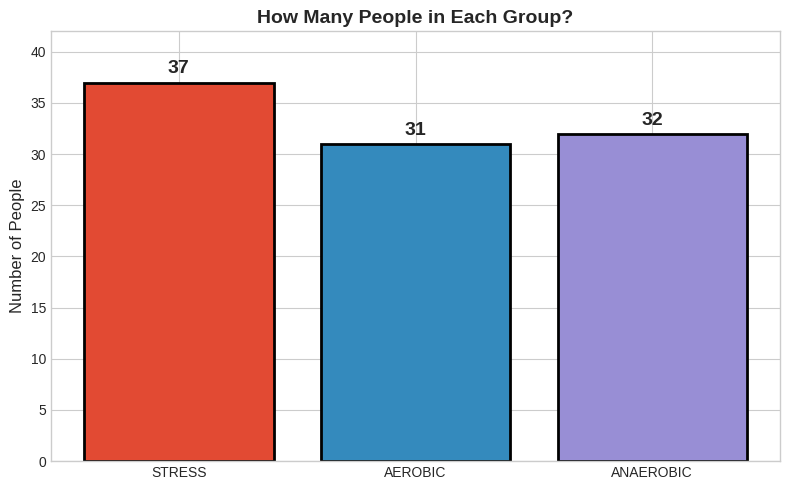


What this chart shows:
Each bar = one group of people
Height = how many people
They're all similar heights = GOOD! Fair comparison.


In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

counts = [len(participants_by_state[s]) for s in STATES]
colors = ['#E24A33', '#348ABD', '#988ED5']  # Red, Blue, Purple

bars = ax.bar(STATES, counts, color=colors, edgecolor='black', linewidth=2)

# Add the numbers on top of each bar
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            str(count), ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Number of People', fontsize=12)
ax.set_title('How Many People in Each Group?', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(counts) + 5)

plt.tight_layout()
plt.show()

print("\nWhat this chart shows:")
print("Each bar = one group of people")
print("Height = how many people")
print("They're all similar heights = GOOD! Fair comparison.")

In [8]:
# Pick the first person from the STRESS group
example_participant = participants_by_state['STRESS'][0]
print(f"Downloading data for: {example_participant} (STRESS group)")
print("(This takes a moment...)\n")

# Download their EDA (sweatiness), HR (heart rate), and ACC (movement)
eda_ex = read_continuous('STRESS', example_participant, 'EDA')
hr_ex = read_continuous('STRESS', example_participant, 'HR')
acc_ex = read_continuous('STRESS', example_participant, 'ACC')

print("Downloaded! Here's what we got:")
print(f"EDA (sweatiness): {len(eda_ex.data):,} measurements")
print(f"HR (heart rate):  {len(hr_ex.data):,} measurements")
print(f"ACC (movement):   {len(acc_ex.data):,} measurements")
print(f"\n   Recording lasted: {eda_ex.t[-1]/60:.1f} minutes")

(This takes a moment...)

Downloaded! Here's what we got:
EDA (sweatiness): 8,898 measurements
HR (heart rate):  2,215 measurements
ACC (movement):   71,178 measurements

   Recording lasted: 37.1 minutes


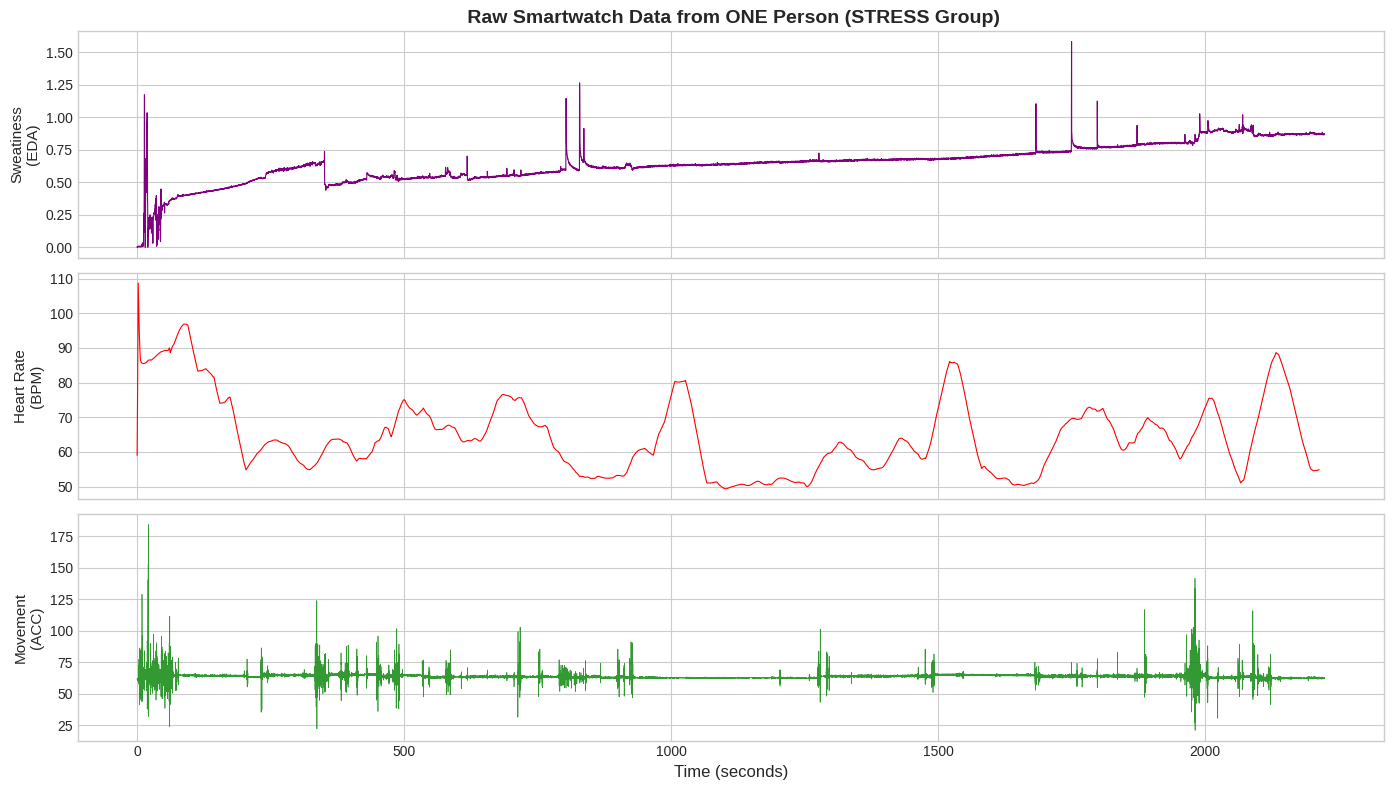


 What you're seeing:
• Top (purple):    Skin sweatiness - wiggles a bit
• Middle (red):    Heart rate - goes up and down (60-90 bpm)
• Bottom (green):  Movement - VERY FLAT!

Why is movement flat?
→ Because the person was SITTING during the stress test!
→ For exercise groups, this line would be MUCH higher and wigglier!


In [9]:
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

# Plot 1: Skin sweatiness (EDA)
axes[0].plot(eda_ex.t, eda_ex.data[:, 0], color='purple', linewidth=0.8)
axes[0].set_ylabel('Sweatiness\n(EDA)', fontsize=11)
axes[0].set_title(' Raw Smartwatch Data from ONE Person (STRESS Group)', fontsize=14, fontweight='bold')

# Plot 2: Heart rate
axes[1].plot(hr_ex.t, hr_ex.data[:, 0], color='red', linewidth=0.8)
axes[1].set_ylabel('Heart Rate\n(BPM)', fontsize=11)

# Plot 3: Movement
acc_mag = np.linalg.norm(acc_ex.data, axis=1)  # Combine X, Y, Z into one number
axes[2].plot(acc_ex.t, acc_mag, color='green', linewidth=0.5, alpha=0.8)
axes[2].set_ylabel('Movement\n(ACC)', fontsize=11)
axes[2].set_xlabel('Time (seconds)', fontsize=12)

plt.tight_layout()
plt.show()

print("\n What you're seeing:")
print("• Top (purple):    Skin sweatiness - wiggles a bit")
print("• Middle (red):    Heart rate - goes up and down (60-90 bpm)")
print("• Bottom (green):  Movement - VERY FLAT!")
print("")
print("Why is movement flat?")
print("→ Because the person was SITTING during the stress test!")
print("→ For exercise groups, this line would be MUCH higher and wigglier!")

## 5. Feature Extraction

In [10]:
def acc_activity(acc: EmpaticaSignal, window_sec: float = 1.0):
    """
    Calculate average movement intensity.
    Takes the 3D accelerometer (X, Y, Z) and combines into one "how much moving" number.
    """
    # Combine X, Y, Z into one number (magnitude)
    mag = np.linalg.norm(acc.data, axis=1)
    win = max(int(window_sec * acc.fs), 1)

    vals, times = [], []
    for i in range(0, len(mag), win):
        chunk = mag[i:i + win]
        if len(chunk) == 0:
            continue
        vals.append(chunk.mean())
        t0 = acc.t[i]
        t1 = acc.t[min(i + win - 1, len(acc.t) - 1)]
        times.append(0.5 * (t0 + t1))

    return np.array(times), np.array(vals)

def hrv_features(ibi: IBISignal, t0: float, t1: float):
    """
    Calculate heart rate variability (HRV) features.
    HRV = how much the time between heartbeats varies.
    Lower HRV can indicate stress.
    """
    if ibi.t.size == 0:
        return dict(ibi_mean=np.nan, ibi_std=np.nan, ibi_rmssd=np.nan)

    mask = (ibi.t >= t0) & (ibi.t < t1)
    if not mask.any():
        return dict(ibi_mean=np.nan, ibi_std=np.nan, ibi_rmssd=np.nan)

    seg = ibi.ibi[mask]

    if len(seg) < 2:
        rmssd = np.nan
    else:
        diff = np.diff(seg)
        rmssd = np.sqrt(np.mean(diff ** 2))

    return dict(
        ibi_mean=float(seg.mean()),
        ibi_std=float(seg.std()),
        ibi_rmssd=float(rmssd),
    )

def segment_bounds(max_t: float, tags, fixed_window: float = 60.0):
    """
    Figure out where to split the recording into segments.
    If there are button-press tags: use those
    If not: use 60-second windows
    """
    bounds = []
    if len(tags) >= 2:
        # Use button-press markers
        for i in range(len(tags) - 1):
            t0, t1 = tags[i], tags[i + 1]
            if t1 > t0:
                bounds.append((t0, t1))
    else:
        # Use fixed 60-second windows
        t0 = 0.0
        while t0 < max_t:
            t1 = min(t0 + fixed_window, max_t)
            if t1 > t0:
                bounds.append((t0, t1))
            t0 = t1
    return bounds

print("Helper functions created!")

Helper functions created!


In [11]:
def extract_features_for_recording(state: str, participant: str):
    """
    This is the main function that:
    1. Downloads all signals for one person
    2. Splits recording into segments
    3. Calculates summary statistics for each segment
    4. Returns a list of feature rows
    """
    # Download all the signals
    eda = read_continuous(state, participant, "EDA")
    hr = read_continuous(state, participant, "HR")
    acc = read_continuous(state, participant, "ACC")

    # Try to get optional signals (might not exist)
    try:
        bvp = read_continuous(state, participant, "BVP")
    except Exception:
        bvp = None

    try:
        temp = read_continuous(state, participant, "TEMP")
    except Exception:
        temp = None

    ibi = read_ibi(state, participant)
    tags = read_tags(state, participant, eda.utc)
    bounds = segment_bounds(float(eda.t[-1]), tags, fixed_window=60.0)
    t_act, act_vals = acc_activity(acc, window_sec=1.0)

    rows = []
    for seg_idx, (t0, t1) in enumerate(bounds):
        duration = float(t1 - t0)

        # Skip segments that are too short or too long
        if duration < 30 or duration > 600:
            continue

        # Find data points within this segment
        m_eda = (eda.t >= t0) & (eda.t < t1)
        m_hr = (hr.t >= t0) & (hr.t < t1)
        m_act = (t_act >= t0) & (t_act < t1)

        if not (m_eda.any() and m_hr.any() and m_act.any()):
            continue

        eda_seg = eda.data[m_eda, 0]
        hr_seg = hr.data[m_hr, 0]
        act_seg = act_vals[m_act]

        # Calculate all the summary statistics!
        row = dict(
            state=state,
            participant=participant,
            segment=seg_idx,
            duration_s=duration,

            # EDA (sweatiness) summaries
            eda_mean=float(eda_seg.mean()),
            eda_std=float(eda_seg.std()),
            eda_min=float(eda_seg.min()),
            eda_max=float(eda_seg.max()),
            eda_range=float(eda_seg.max() - eda_seg.min()),

            # HR (heart rate) summaries
            hr_mean=float(hr_seg.mean()),
            hr_std=float(hr_seg.std()),
            hr_min=float(hr_seg.min()),
            hr_max=float(hr_seg.max()),
            hr_range=float(hr_seg.max() - hr_seg.min()),

            # ACC (movement) summaries
            acc_mean=float(act_seg.mean()),
            acc_std=float(act_seg.std()),
        )

        # Add optional signals if available
        if bvp is not None:
            m_bvp = (bvp.t >= t0) & (bvp.t < t1)
            if m_bvp.any():
                bvp_seg = bvp.data[m_bvp, 0]
                row.update(bvp_mean=float(bvp_seg.mean()), bvp_std=float(bvp_seg.std()))
            else:
                row.update(bvp_mean=np.nan, bvp_std=np.nan)
        else:
            row.update(bvp_mean=np.nan, bvp_std=np.nan)

        if temp is not None:
            m_temp = (temp.t >= t0) & (temp.t < t1)
            if m_temp.any():
                temp_seg = temp.data[m_temp, 0]
                row.update(temp_mean=float(temp_seg.mean()), temp_std=float(temp_seg.std()))
            else:
                row.update(temp_mean=np.nan, temp_std=np.nan)
        else:
            row.update(temp_mean=np.nan, temp_std=np.nan)

        row.update(hrv_features(ibi, t0, t1))
        rows.append(row)

    return rows

print("Main extraction function ready!")

Main extraction function ready!


In [12]:
print("Starting to extract features from ALL recordings!")
print("(This takes 3-5 minutes - downloading from internet)")
print("" + "="*50 + "\n")

all_rows = []
for st in STATES:

    print(f"Processing {st}...")

    for i, p in enumerate(participants_by_state[st]):
        try:
            rows = extract_features_for_recording(st, p)
            all_rows.extend(rows)
            if (i + 1) % 5 == 0:
                print(f"{i+1}/{len(participants_by_state[st])} done")
        except Exception as e:
            print(f"Skipped {p}: {e}")
    print(f"Finished {st}\n")

features_df = pd.DataFrame(all_rows)

print("-" * 40)
print(f"DONE! Extracted {len(features_df)} segments total!")
print(f"Each segment has {features_df.shape[1]} summary numbers.")

Starting to extract features from ALL recordings!
(This takes 3-5 minutes - downloading from internet)

Processing STRESS...
Skipped S02: unconverted data remains: .828125
5/37 done
10/37 done
15/37 done
20/37 done
25/37 done
30/37 done
35/37 done
Finished STRESS

Processing AEROBIC...
5/31 done
10/31 done
15/31 done
20/31 done
25/31 done
30/31 done
Finished AEROBIC

Processing ANAEROBIC...
5/32 done
10/32 done
15/32 done
20/32 done
25/32 done
30/32 done
Finished ANAEROBIC

----------------------------------------
DONE! Extracted 771 segments total!
Each segment has 23 summary numbers.


In [13]:
# Sometimes sensors give crazy numbers (like heart rate of 500!)
# We "clip" these to reasonable ranges

features_df_clean = features_df.copy()

# Sweatiness should be 0-20 (microSiemens)
features_df_clean["eda_mean"] = features_df_clean["eda_mean"].clip(lower=0, upper=20)
features_df_clean["eda_max"] = features_df_clean["eda_max"].clip(lower=0, upper=30)

# Heart rate should be 40-200 (beats per minute)
features_df_clean["hr_mean"] = features_df_clean["hr_mean"].clip(lower=40, upper=200)
features_df_clean["hr_max"] = features_df_clean["hr_max"].clip(lower=40, upper=220)

print("Cleaned! Here's how many segments we have per group:")
print()
for state, count in features_df_clean["state"].value_counts().items():

    print(f"{state}: {count} segments")

Cleaned! Here's how many segments we have per group:

STRESS: 290 segments
AEROBIC: 257 segments
ANAEROBIC: 224 segments


## 6. Exploratory Data Analysis

In [14]:
summary = features_df_clean.groupby('state')[['hr_mean', 'eda_mean', 'acc_mean']].mean()

print("Average values for each group:")
print("-" * 40)
print()
print(summary.round(1).to_string())
print()
print("-" * 40)
print()
print("What does this mean?")
print()
print("Heart Rate (hr_mean):")
print("STRESS: ~80 bpm (sitting, a bit nervous)")
print("AEROBIC: ~103 bpm (exercising, heart pumping!)")
print("ANAEROBIC: ~99 bpm (intense bursts!)")
print()
print("Sweatiness (eda_mean):")
print("STRESS: ~3.7 (a little sweaty from nerves)")
print("AEROBIC: ~7.5 (sweating from exercise!)")
print("ANAEROBIC: ~6.5 (sweating from sprints!)")
print()
print("Movement (acc_mean):")
print("All similar - interesting! (will look deeper)")

Average values for each group:
----------------------------------------

           hr_mean  eda_mean  acc_mean
state                                 
AEROBIC      103.1       7.5      64.1
ANAEROBIC     98.8       6.5      68.3
STRESS        79.7       3.7      63.3

----------------------------------------

What does this mean?

Heart Rate (hr_mean):
STRESS: ~80 bpm (sitting, a bit nervous)
AEROBIC: ~103 bpm (exercising, heart pumping!)
ANAEROBIC: ~99 bpm (intense bursts!)

Sweatiness (eda_mean):
STRESS: ~3.7 (a little sweaty from nerves)
AEROBIC: ~7.5 (sweating from exercise!)
ANAEROBIC: ~6.5 (sweating from sprints!)

Movement (acc_mean):
All similar - interesting! (will look deeper)


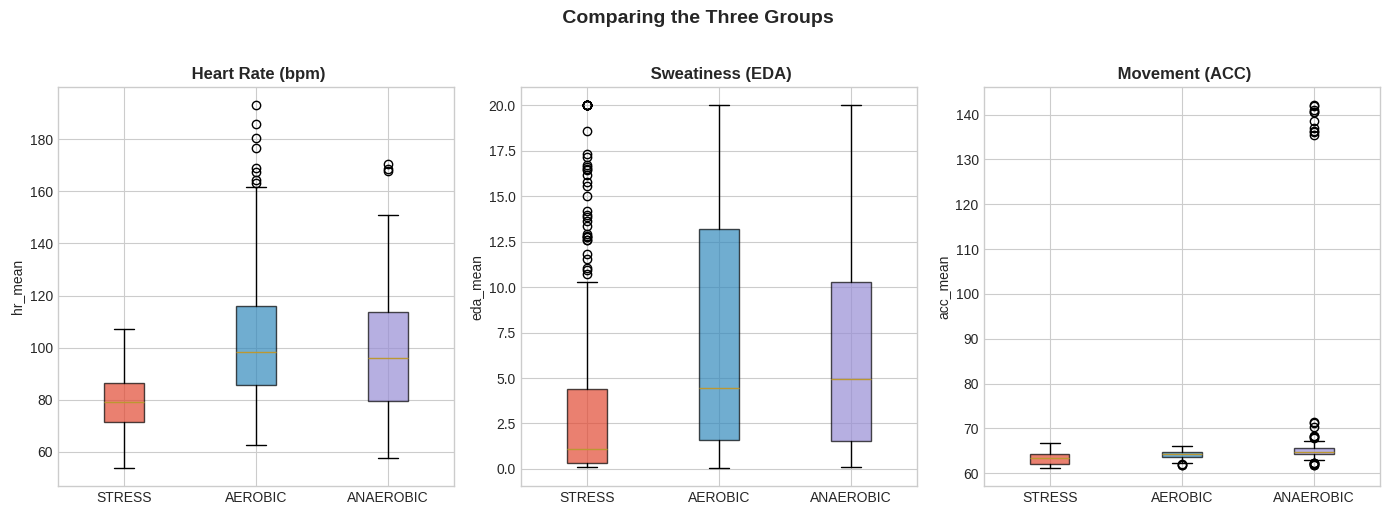


 How to read these boxplots:
• The box shows where MOST values are (middle 50%)
• The line in the middle is the MEDIAN (typical value)
• Dots outside are unusual values (outliers)

What we see:
• Heart rate: STRESS is LOW, exercise groups are HIGH
• Sweatiness: STRESS is LOW, exercise groups are HIGHER
• Movement: Some overlap, but STRESS tends to be lower

Good news: The groups ARE different! A computer should be able to tell them apart!


In [15]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# What we're plotting
plot_info = [
    ('hr_mean', ' Heart Rate (bpm)', 'Average heart rate'),
    ('eda_mean', ' Sweatiness (EDA)', 'Skin conductance'),
    ('acc_mean', ' Movement (ACC)', 'How much moving'),
]

colors = ['#E24A33', '#348ABD', '#988ED5']

for ax, (col, title, _) in zip(axes, plot_info):
    data_to_plot = [features_df_clean[features_df_clean['state'] == s][col].dropna() for s in STATES]
    bp = ax.boxplot(data_to_plot, labels=STATES, patch_artist=True)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(col)

plt.suptitle(' Comparing the Three Groups', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n How to read these boxplots:")
print("• The box shows where MOST values are (middle 50%)")
print("• The line in the middle is the MEDIAN (typical value)")
print("• Dots outside are unusual values (outliers)")
print()
print("What we see:")
print("• Heart rate: STRESS is LOW, exercise groups are HIGH")
print("• Sweatiness: STRESS is LOW, exercise groups are HIGHER")
print("• Movement: Some overlap, but STRESS tends to be lower")
print()
print("Good news: The groups ARE different! A computer should be able to tell them apart!")

## 7. Activity Classification

In [16]:
# Which numbers will we use to make predictions?
feature_cols_state = [
    "duration_s",                                           # How long was the segment
    "eda_mean", "eda_std", "eda_min", "eda_max", "eda_range",  # Sweatiness stats
    "hr_mean", "hr_std", "hr_min", "hr_max", "hr_range",       # Heart rate stats
    "acc_mean", "acc_std",                                     # Movement stats
]

# Remove rows with missing values
df_state = features_df_clean.dropna(subset=feature_cols_state)

# X = the input numbers (features)
# y = the answer we want to predict (state)
X_state = df_state[feature_cols_state].values
y_state = df_state["state"].values

print("Data prepared!")
print(f"Total examples: {len(X_state)}")
print(f"Numbers per example: {len(feature_cols_state)}")
print()
print("How many in each group:")
for s in STATES:
    count = np.sum(y_state == s)

    print(f"{s}: {count} ({100*count/len(y_state):.0f}%)")

Data prepared!
Total examples: 771
Numbers per example: 13

How many in each group:
STRESS: 290 (38%)
AEROBIC: 257 (33%)
ANAEROBIC: 224 (29%)


In [17]:
# 75% for training (studying)
# 25% for testing (the actual exam)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_state, y_state,
    test_size=0.25,           # 25% for testing
    random_state=RANDOM_STATE, # Same split every time
    stratify=y_state          # Keep same % of each group
)

print("Data split!")
print(f"Training examples: {len(X_train_s)} (for learning)")
print(f"Testing examples:  {len(X_test_s)} (for checking)")

Data split!
Training examples: 578 (for learning)
Testing examples:  193 (for checking)


In [18]:
# We're using a "Random Forest" - it's like asking 300 experts to vote!
# Each expert ("tree") looks at the data differently
# The final answer is what most experts agree on

print("Training a Random Forest (300 trees)...")
print("(This takes a few seconds)\n")

clf_state = Pipeline([
    ("scaler", StandardScaler()),  # Make all numbers similar scale
    ("rf", RandomForestClassifier(
        n_estimators=300,           # 300 decision trees
        class_weight="balanced",    # Pay equal attention to all groups
        random_state=RANDOM_STATE,
        n_jobs=-1                   # Use all CPU cores
    ))
])

clf_state.fit(X_train_s, y_train_s)  # TRAIN!
y_pred_s = clf_state.predict(X_test_s)  # PREDICT on test data!

print("Training complete!")
print("The computer has learned the patterns!")

Training a Random Forest (300 trees)...
(This takes a few seconds)

Training complete!
The computer has learned the patterns!


In [19]:
print("Results: How well did the computer do?")
print("-" * 40)
print()
print(classification_report(y_test_s, y_pred_s))
print("-" * 40)
print()
print("What does this mean?")
print()
print("ACCURACY = ~83%")
print("→ The computer guessed correctly 83% of the time!")
print("→ That's like getting a B on a test!")
print()
print("PRECISION = When it guesses 'STRESS', it's right ~81% of the time")
print("RECALL = It correctly identifies ~92% of actual STRESS examples")

Results: How well did the computer do?
----------------------------------------

              precision    recall  f1-score   support

     AEROBIC       0.83      0.75      0.79        64
   ANAEROBIC       0.87      0.80      0.83        56
      STRESS       0.81      0.92      0.86        73

    accuracy                           0.83       193
   macro avg       0.83      0.82      0.83       193
weighted avg       0.83      0.83      0.83       193

----------------------------------------

What does this mean?

ACCURACY = ~83%
→ The computer guessed correctly 83% of the time!
→ That's like getting a B on a test!

PRECISION = When it guesses 'STRESS', it's right ~81% of the time
RECALL = It correctly identifies ~92% of actual STRESS examples


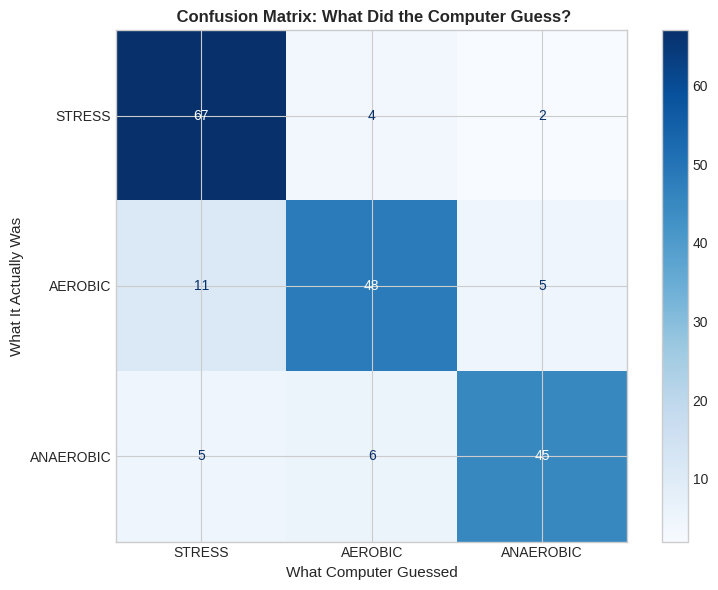


 How to read this:
• Each row = what the answer ACTUALLY was
• Each column = what the computer GUESSED
• Numbers on the DIAGONAL = CORRECT guesses 
• Numbers OFF the diagonal = MISTAKES 

What we see:
• STRESS: Very few mistakes! Computer knows sitting vs exercising.
• AEROBIC/ANAEROBIC: Sometimes confused with each other.
(Makes sense - both involve exercising!)


In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

cm = confusion_matrix(y_test_s, y_pred_s, labels=STATES)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=STATES)
disp.plot(ax=ax, cmap='Blues', values_format='d')

ax.set_title(' Confusion Matrix: What Did the Computer Guess?', fontsize=12, fontweight='bold')
ax.set_xlabel('What Computer Guessed', fontsize=11)
ax.set_ylabel('What It Actually Was', fontsize=11)

plt.tight_layout()
plt.show()

print("\n How to read this:")
print("• Each row = what the answer ACTUALLY was")
print("• Each column = what the computer GUESSED")
print("• Numbers on the DIAGONAL = CORRECT guesses ")
print("• Numbers OFF the diagonal = MISTAKES ")
print()
print("What we see:")
print("• STRESS: Very few mistakes! Computer knows sitting vs exercising.")
print("• AEROBIC/ANAEROBIC: Sometimes confused with each other.")
print("(Makes sense - both involve exercising!)")

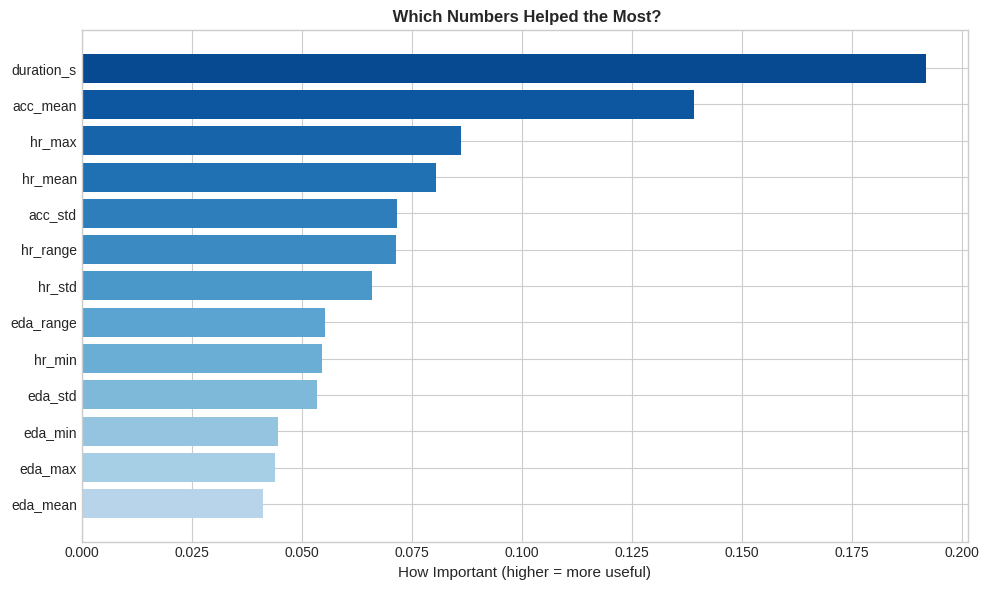


 Top 5 most helpful features:

1. duration_s: 0.192 (STRESS segments are longer than 60-sec exercise windows)
2. acc_mean: 0.139 (Movement clearly separates sitting from exercising)
3. hr_max: 0.086 (Peak heart rate is higher during exercise)
4. hr_mean: 0.081 (Average heart rate differs a lot)
5. acc_std: 0.072 (Movement variability - steady vs changing)


In [21]:
rf_model = clf_state.named_steps['rf']
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(sorted_idx)))
ax.barh(range(len(sorted_idx)), importances[sorted_idx], color=colors)
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels([feature_cols_state[i] for i in sorted_idx])
ax.set_xlabel('How Important (higher = more useful)', fontsize=11)
ax.set_title(' Which Numbers Helped the Most?', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Top 5 most helpful features:")
print()
for i, idx in enumerate(sorted_idx[-5:][::-1], 1):
    name = feature_cols_state[idx]
    score = importances[idx]

    explanation = {
        'duration_s': '(STRESS segments are longer than 60-sec exercise windows)',
        'acc_mean': '(Movement clearly separates sitting from exercising)',
        'hr_max': '(Peak heart rate is higher during exercise)',
        'hr_mean': '(Average heart rate differs a lot)',
        'acc_std': '(Movement variability - steady vs changing)',
    }.get(name, '')

    print(f"{i}. {name}: {score:.3f} {explanation}")

## 7A. Model Comparison

In [22]:
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
import time

# Define models to compare
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=300,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'AdaBoost': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=300,
        random_state=RANDOM_STATE,
        algorithm='SAMME'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=300,
        max_depth=3,
        random_state=RANDOM_STATE
    )
}

print("Comparing classification algorithms...")
print("(This may take a minute)\n")
print("=" * 70)

results = {}
for name, model in models.items():
    print(f"\n Training {name}...")

    start_time = time.time()

    # Cross-validation
    cv_scores = cross_val_score(model, X_state, y_state, cv=5, scoring='accuracy')

    # Train on full training set for detailed analysis
    model.fit(X_train_s, y_train_s)
    y_pred = model.predict(X_test_s)
    test_acc = (y_pred == y_test_s).mean()

    train_time = time.time() - start_time

    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_acc': test_acc,
        'train_time': train_time,
        'model': model,
        'predictions': y_pred
    }

    print(f"CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")
    print(f"Training time: {train_time:.1f}s")

print("\n" + "=" * 70)

Comparing classification algorithms...
(This may take a minute)


 Training Random Forest...
CV Accuracy: 0.760 ± 0.089
Test Accuracy: 0.829
Training time: 6.2s

 Training AdaBoost...
CV Accuracy: 0.780 ± 0.068
Test Accuracy: 0.829
Training time: 13.4s

 Training Gradient Boosting...
CV Accuracy: 0.778 ± 0.055
Test Accuracy: 0.845
Training time: 31.4s



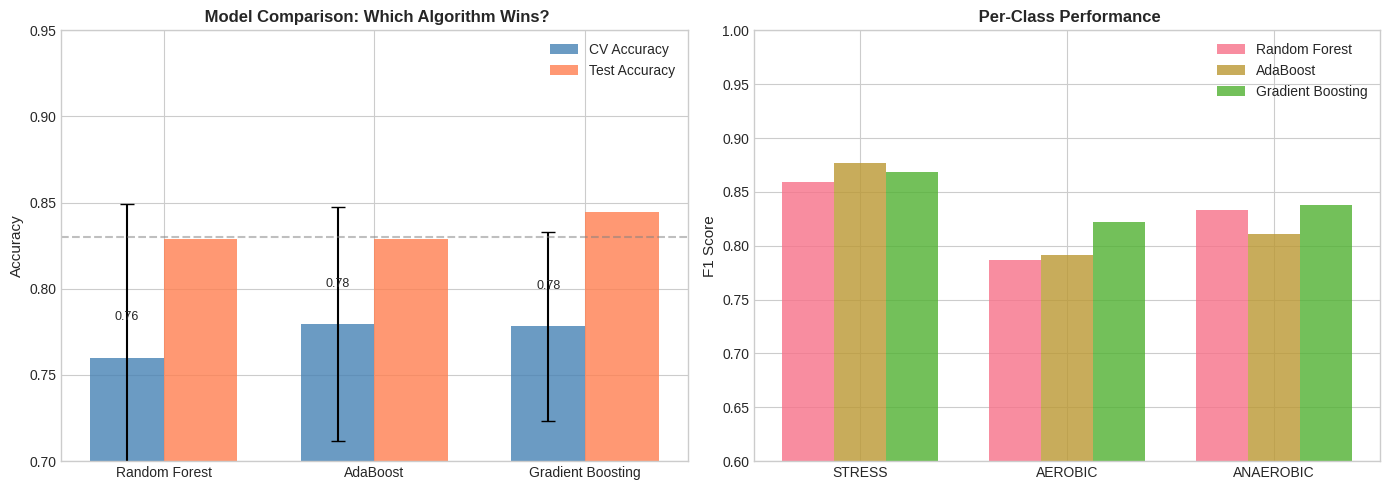


 KEY FINDINGS:
Best overall model: AdaBoost (CV: 0.780)


In [23]:
from sklearn.metrics import f1_score

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy Comparison
model_names = list(results.keys())
cv_means = [results[m]['cv_mean'] for m in model_names]
cv_stds = [results[m]['cv_std'] for m in model_names]
test_accs = [results[m]['test_acc'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = axes[0].bar(x - width/2, cv_means, width, label='CV Accuracy',
                     yerr=cv_stds, capsize=5, color='steelblue', alpha=0.8)
bars2 = axes[0].bar(x + width/2, test_accs, width, label='Test Accuracy',
                     color='coral', alpha=0.8)

axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title(' Model Comparison: Which Algorithm Wins?', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names)
axes[0].legend()
axes[0].set_ylim(0.7, 0.95)
axes[0].axhline(y=0.83, color='gray', linestyle='--', alpha=0.5)

# Add value labels
for bar, val in zip(bars1, cv_means):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Per-Class F1 Scores
class_f1_scores = {}
for name in model_names:
    y_pred = results[name]['predictions']
    for state in STATES:
        if state not in class_f1_scores:
            class_f1_scores[state] = []
        y_true_binary = (y_test_s == state).astype(int)
        y_pred_binary = (y_pred == state).astype(int)
        f1 = f1_score(y_true_binary, y_pred_binary)
        class_f1_scores[state].append(f1)

x = np.arange(len(STATES))
width = 0.25
for i, name in enumerate(model_names):
    f1_vals = [class_f1_scores[state][i] for state in STATES]
    axes[1].bar(x + i*width, f1_vals, width, label=name, alpha=0.8)

axes[1].set_ylabel('F1 Score', fontsize=11)
axes[1].set_title(' Per-Class Performance', fontsize=12, fontweight='bold')
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(STATES)
axes[1].legend()
axes[1].set_ylim(0.6, 1.0)

plt.tight_layout()
plt.show()

# Summary
print("\n KEY FINDINGS:")
best_model = max(results.keys(), key=lambda m: results[m]['cv_mean'])
print(f"Best overall model: {best_model} (CV: {results[best_model]['cv_mean']:.3f})")

In [24]:
print("DEEP DIVE: Model Disagreements\n")

# Get predictions from each model
rf_pred = results['Random Forest']['predictions']
ab_pred = results['AdaBoost']['predictions']
gb_pred = results['Gradient Boosting']['predictions']

# Find samples where models disagree
disagreement_mask = ~((rf_pred == ab_pred) & (ab_pred == gb_pred))
agreement_mask = (rf_pred == ab_pred) & (ab_pred == gb_pred)

print(f"Models AGREE on: {agreement_mask.sum()} samples ({100*agreement_mask.mean():.1f}%)")
print(f"Models DISAGREE on: {disagreement_mask.sum()} samples ({100*disagreement_mask.mean():.1f}%)")
print()

# Analyze disagreement cases
test_features_df = pd.DataFrame(X_test_s, columns=feature_cols_state)
test_features_df['true_label'] = y_test_s
test_features_df['RF_correct'] = rf_pred == y_test_s
test_features_df['GB_correct'] = gb_pred == y_test_s

# Where does boosting succeed but RF fails?
boost_wins = test_features_df[(test_features_df['GB_correct']) & (~test_features_df['RF_correct'])]
rf_wins = test_features_df[(test_features_df['RF_correct']) & (~test_features_df['GB_correct'])]

print("BOOSTING vs RANDOM FOREST:")
print(f"Gradient Boosting correct when RF wrong: {len(boost_wins)} samples")
print(f"Random Forest correct when GB wrong: {len(rf_wins)} samples")

if len(boost_wins) > 0:
    print(f"\n   Samples where Boosting wins have:")
    print(f"• Avg HR: {boost_wins['hr_mean'].mean():.1f} (vs overall {test_features_df['hr_mean'].mean():.1f})")
    print(f"• Avg ACC: {boost_wins['acc_mean'].mean():.1f} (vs overall {test_features_df['acc_mean'].mean():.1f})")
    print(f"• True labels: {boost_wins['true_label'].value_counts().to_dict()}")

DEEP DIVE: Model Disagreements

Models AGREE on: 168 samples (87.0%)
Models DISAGREE on: 25 samples (13.0%)

BOOSTING vs RANDOM FOREST:
Gradient Boosting correct when RF wrong: 7 samples
Random Forest correct when GB wrong: 4 samples

   Samples where Boosting wins have:
• Avg HR: 89.1 (vs overall 93.7)
• Avg ACC: 64.6 (vs overall 64.4)
• True labels: {'AEROBIC': 6, 'STRESS': 1}


## 7B. Clustering Analysis

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Standardize features for clustering
scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(X_state)

# Find optimal number of clusters using silhouette score
print("Finding optimal number of clusters...\n")

silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.3f}")

best_k = K_range[np.argmax(silhouette_scores)]
print(f"\n Best K = {best_k} (highest silhouette score: {max(silhouette_scores):.3f})")

# Fit final clustering model
kmeans_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to our data
cluster_df = df_state.copy()
cluster_df['cluster'] = cluster_labels

print(f"\n Cluster sizes:")
for c in range(best_k):
    count = (cluster_labels == c).sum()
    print(f"Cluster {c}: {count} samples ({100*count/len(cluster_labels):.1f}%)")

Finding optimal number of clusters...

K=2: Silhouette Score = 0.390
K=3: Silhouette Score = 0.356
K=4: Silhouette Score = 0.371
K=5: Silhouette Score = 0.276
K=6: Silhouette Score = 0.293
K=7: Silhouette Score = 0.213

 Best K = 2 (highest silhouette score: 0.390)

 Cluster sizes:
Cluster 0: 582 samples (75.5%)
Cluster 1: 189 samples (24.5%)


In [26]:
# Train a classifier on the same scaled data used for clustering
# to analyze which clusters are harder to classify

from sklearn.ensemble import GradientBoostingClassifier

# Use X_scaled (already created above from scaler_cluster)
gb_cluster = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=RANDOM_STATE)
gb_cluster.fit(X_scaled, y_state)
y_pred_clusters = gb_cluster.predict(X_scaled)

# Add predictions to cluster_df
cluster_df['predicted'] = y_pred_clusters
cluster_df['correct'] = cluster_df['state'] == cluster_df['predicted']

print("ERROR ANALYSIS BY CLUSTER:\n")
print("=" * 70)

cluster_stats = []
for c in range(best_k):
    cluster_mask = cluster_df['cluster'] == c
    cluster_data = cluster_df[cluster_mask]

    if len(cluster_data) == 0:
        continue

    accuracy = cluster_data['correct'].mean()
    n_samples = len(cluster_data)

    # State distribution
    state_dist = cluster_data['state'].value_counts(normalize=True)
    dominant_state = state_dist.index[0]
    dominant_pct = state_dist.iloc[0]

    # Feature averages
    hr_mean = cluster_data['hr_mean'].mean()
    acc_mean = cluster_data['acc_mean'].mean()
    eda_mean = cluster_data['eda_mean'].mean()

    cluster_stats.append({
        'cluster': c, 'n_samples': n_samples, 'accuracy': accuracy,
        'dominant_state': dominant_state, 'dominant_pct': dominant_pct,
        'hr_mean': hr_mean, 'acc_mean': acc_mean, 'eda_mean': eda_mean
    })

    print(f"\nCluster {c} ")
    print(f"Samples: {n_samples} | Accuracy: {accuracy:.1%}")
    print(f"Dominant state: {dominant_state} ({dominant_pct:.1%})")
    print(f"Avg HR: {hr_mean:.1f} | ACC: {acc_mean:.1f} | EDA: {eda_mean:.2f}")

cluster_stats_df = pd.DataFrame(cluster_stats)
print("\n" + "=" * 70)

ERROR ANALYSIS BY CLUSTER:


Cluster 0 
Samples: 582 | Accuracy: 99.0%
Dominant state: STRESS (47.3%)
Avg HR: 85.4 | ACC: 65.2 | EDA: 3.05

Cluster 1 
Samples: 189 | Accuracy: 100.0%
Dominant state: AEROBIC (49.7%)
Avg HR: 116.7 | ACC: 64.4 | EDA: 14.25



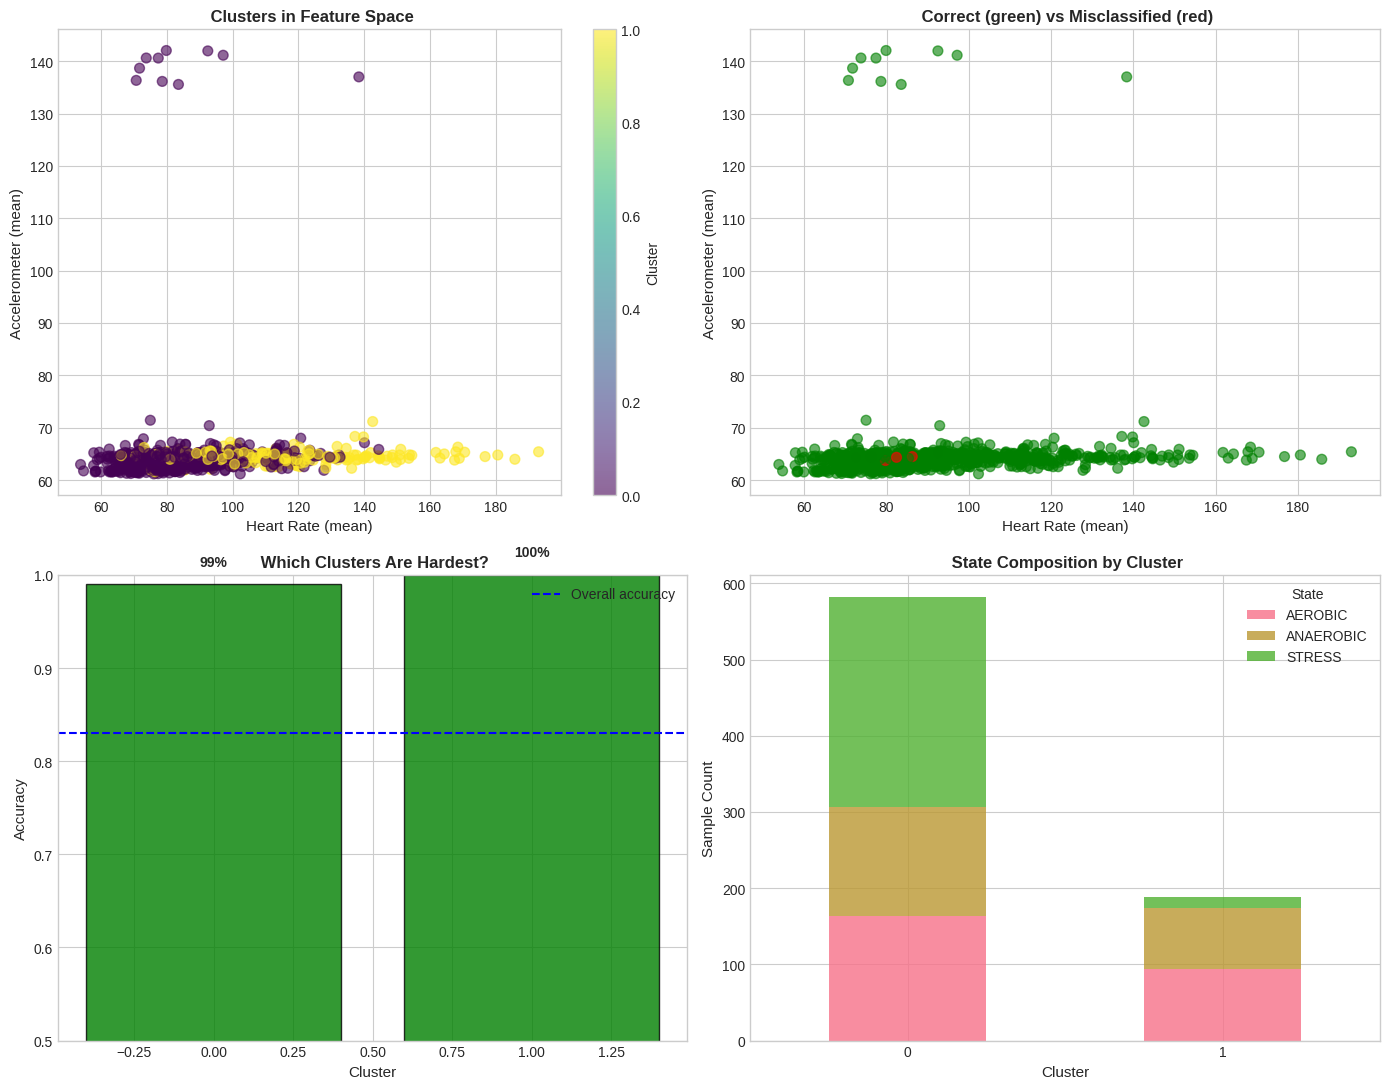

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# Plot 1: Clusters in HR vs ACC space
ax = axes[0, 0]
scatter = ax.scatter(cluster_df['hr_mean'], cluster_df['acc_mean'],
                     c=cluster_df['cluster'], cmap='viridis', alpha=0.6, s=50)
ax.set_xlabel('Heart Rate (mean)', fontsize=11)
ax.set_ylabel('Accelerometer (mean)', fontsize=11)
ax.set_title(' Clusters in Feature Space', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Cluster')

# Plot 2: Correct vs Incorrect by cluster
ax = axes[0, 1]
correct_color = cluster_df['correct'].map({True: 'green', False: 'red'})
ax.scatter(cluster_df['hr_mean'], cluster_df['acc_mean'],
           c=correct_color, alpha=0.6, s=50)
ax.set_xlabel('Heart Rate (mean)', fontsize=11)
ax.set_ylabel('Accelerometer (mean)', fontsize=11)
ax.set_title(' Correct (green) vs Misclassified (red)', fontsize=12, fontweight='bold')

# Plot 3: Accuracy by cluster
ax = axes[1, 0]
colors = ['green' if acc > 0.85 else 'orange' if acc > 0.75 else 'red'
          for acc in cluster_stats_df['accuracy']]
bars = ax.bar(cluster_stats_df['cluster'], cluster_stats_df['accuracy'],
              color=colors, edgecolor='black', alpha=0.8)
ax.axhline(y=0.83, color='blue', linestyle='--', label='Overall accuracy')
ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title(' Which Clusters Are Hardest?', fontsize=12, fontweight='bold')
ax.set_ylim(0.5, 1.0)
ax.legend()

for bar, acc in zip(bars, cluster_stats_df['accuracy']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{acc:.0%}', ha='center', fontsize=10, fontweight='bold')

# Plot 4: State composition by cluster
ax = axes[1, 1]
cluster_state_counts = cluster_df.groupby(['cluster', 'state']).size().unstack(fill_value=0)
cluster_state_counts.plot(kind='bar', stacked=True, ax=ax, alpha=0.8)
ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Sample Count', fontsize=11)
ax.set_title(' State Composition by Cluster', fontsize=12, fontweight='bold')
ax.legend(title='State')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [28]:
print("\n" + "=" * 70)
print("KEY INSIGHTS FROM CLUSTERING")
print("=" * 70)

worst_cluster = cluster_stats_df.loc[cluster_stats_df['accuracy'].idxmin()]
best_cluster = cluster_stats_df.loc[cluster_stats_df['accuracy'].idxmax()]

print(f"\n HARDEST CLUSTER (Cluster {int(worst_cluster['cluster'])})")
print(f"• Accuracy: {worst_cluster['accuracy']:.1%}")
print(f"• Avg HR: {worst_cluster['hr_mean']:.1f} | ACC: {worst_cluster['acc_mean']:.1f}")
print(f"• Dominant state: {worst_cluster['dominant_state']}")

print(f"\n EASIEST CLUSTER (Cluster {int(best_cluster['cluster'])})")
print(f"• Accuracy: {best_cluster['accuracy']:.1%}")
print(f"• Avg HR: {best_cluster['hr_mean']:.1f} | ACC: {best_cluster['acc_mean']:.1f}")
print(f"• Dominant state: {best_cluster['dominant_state']}")

# Misclassification patterns
misclassified = cluster_df[~cluster_df['correct']]
print(f"\n MISCLASSIFICATION PATTERNS:")
print(f"Total misclassified: {len(misclassified)} samples")
for state in STATES:
    state_errors = misclassified[misclassified['state'] == state]
    if len(state_errors) > 0:
        confused = state_errors['predicted'].value_counts().to_dict()
        print(f"• {state} confused with: {confused}")

print(f"\n   Errors concentrated in clusters:")
error_by_cluster = misclassified['cluster'].value_counts().sort_index()
for c, count in error_by_cluster.items():
    pct = 100*count/len(misclassified)
    print(f"• Cluster {c}: {count} errors ({pct:.0f}% of all errors)")


KEY INSIGHTS FROM CLUSTERING

 HARDEST CLUSTER (Cluster 0)
• Accuracy: 99.0%
• Avg HR: 85.4 | ACC: 65.2
• Dominant state: STRESS

 EASIEST CLUSTER (Cluster 1)
• Accuracy: 100.0%
• Avg HR: 116.7 | ACC: 64.4
• Dominant state: AEROBIC

 MISCLASSIFICATION PATTERNS:
Total misclassified: 6 samples
• STRESS confused with: {'AEROBIC': 2}
• AEROBIC confused with: {'ANAEROBIC': 1}
• ANAEROBIC confused with: {'STRESS': 2, 'AEROBIC': 1}

   Errors concentrated in clusters:
• Cluster 0: 6 errors (100% of all errors)


## 7C. Error Analysis

## Analysis 1: Feature Distributions - Correct vs Incorrect

**Question:** What features differ between correctly and incorrectly classified samples?

In [29]:
from scipy import stats

# Get predictions and identify errors
y_pred_analysis = clf_state.predict(X_test_s)
correct_mask = (y_pred_analysis == y_test_s)
incorrect_mask = ~correct_mask

# Create DataFrame for analysis
test_df = pd.DataFrame(X_test_s, columns=feature_cols_state)
test_df['true_label'] = y_test_s
test_df['predicted'] = y_pred_analysis
test_df['correct'] = correct_mask

print("=" * 70)
print("ANALYSIS 1: FEATURE COMPARISON - CORRECT vs INCORRECT")
print("=" * 70)
print(f"\n   Correctly classified:   {correct_mask.sum()} samples ({100*correct_mask.mean():.1f}%)")
print(f"Incorrectly classified: {incorrect_mask.sum()} samples ({100*incorrect_mask.mean():.1f}%)")

# Compare feature means for correct vs incorrect
print("\n   Feature Means Comparison:")
print("" + "-" * 60)
print(f"{'Feature':<15} {'Correct':>12} {'Incorrect':>12} {'Difference':>12}")
print("" + "-" * 60)

significant_features = []
for col in feature_cols_state:
    correct_mean = test_df.loc[correct_mask, col].mean()
    incorrect_mean = test_df.loc[incorrect_mask, col].mean() if incorrect_mask.sum() > 0 else 0
    diff_pct = 100 * (incorrect_mean - correct_mean) / (correct_mean + 1e-10)

    # Statistical test
    sig = ""
    if incorrect_mask.sum() >= 2:
        try:
            t_stat, p_val = stats.ttest_ind(
                test_df.loc[correct_mask, col],
                test_df.loc[incorrect_mask, col]
            )
            sig = "***" if p_val < 0.01 else "**" if p_val < 0.05 else "*" if p_val < 0.1 else ""
            if p_val < 0.1:
                significant_features.append((col, diff_pct, p_val))
        except:
            pass

    print(f"{col:<15} {correct_mean:>12.2f} {incorrect_mean:>12.2f} {diff_pct:>+11.1f}% {sig}")

print("" + "-" * 60)
print("(* p<0.1, ** p<0.05, *** p<0.01)")

if significant_features:
    print("\n    KEY INSIGHT: Features most different in misclassified samples:")
    for feat, diff, pval in sorted(significant_features, key=lambda x: abs(x[1]), reverse=True)[:3]:
        direction = "HIGHER" if diff > 0 else "LOWER"
        print(f"• {feat}: {abs(diff):.1f}% {direction} (p={pval:.3f})")

ANALYSIS 1: FEATURE COMPARISON - CORRECT vs INCORRECT

   Correctly classified:   160 samples (82.9%)
Incorrectly classified: 33 samples (17.1%)

   Feature Means Comparison:
------------------------------------------------------------
Feature              Correct    Incorrect   Difference
------------------------------------------------------------
duration_s            133.44       147.73       +10.7% 
eda_mean                6.12         4.72       -22.8% 
eda_std                 0.78         0.61       -21.8% 
eda_min                 5.39         3.58       -33.7% 
eda_max                 8.17         6.06       -25.9% 
eda_range               3.22         2.55       -20.8% 
hr_mean                94.89        87.69        -7.6% 
hr_std                  5.02         6.74       +34.1% 
hr_min                 87.14        76.54       -12.2% **
hr_max                103.39        98.18        -5.0% 
hr_range               16.25        21.64       +33.2% 
acc_mean               64.42  

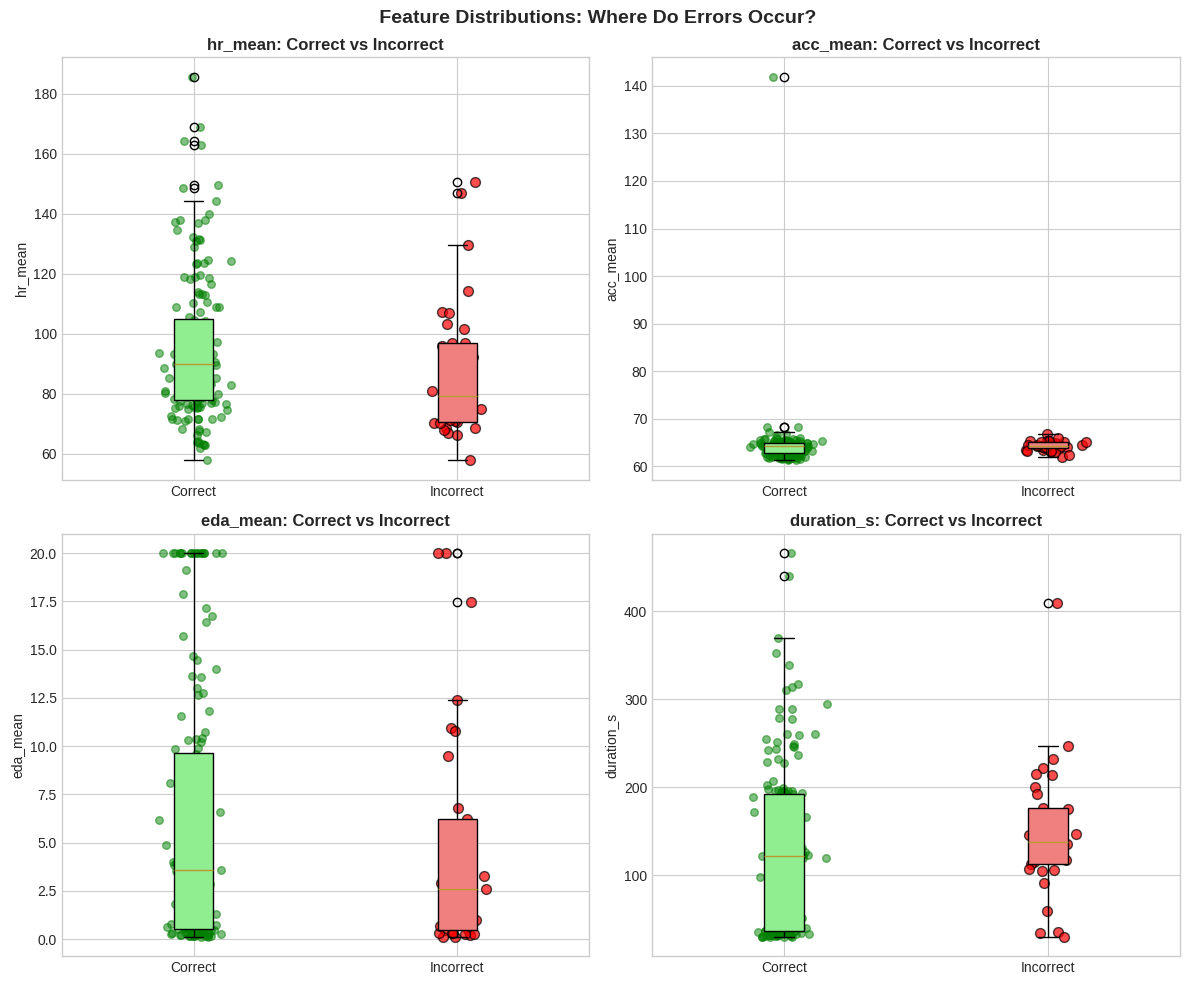


 INSIGHT: Look for features where RED points (errors) cluster at extreme
values or overlap between classes - these are problematic regions.


In [30]:
# Select top features to visualize
top_features = ['hr_mean', 'acc_mean', 'eda_mean', 'duration_s']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, feat in zip(axes, top_features):
    # Get data
    data_correct = test_df.loc[correct_mask, feat]
    data_incorrect = test_df.loc[incorrect_mask, feat]

    # Box plot comparison
    bp = ax.boxplot([data_correct, data_incorrect], labels=['Correct', 'Incorrect'],
                    patch_artist=True)
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')

    # Overlay individual points
    ax.scatter(np.ones(len(data_correct)) + np.random.normal(0, 0.05, len(data_correct)),
               data_correct, alpha=0.5, color='green', s=30)
    ax.scatter(np.ones(len(data_incorrect))*2 + np.random.normal(0, 0.05, len(data_incorrect)),
               data_incorrect, alpha=0.7, color='red', s=50, edgecolors='black')

    ax.set_ylabel(feat)
    ax.set_title(f'{feat}: Correct vs Incorrect', fontweight='bold')

plt.suptitle(' Feature Distributions: Where Do Errors Occur?', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n INSIGHT: Look for features where RED points (errors) cluster at extreme")
print("values or overlap between classes - these are problematic regions.")

## Analysis 2: Prediction Confidence - Does the Model Know When It's Wrong?

**Question:** Is the model uncertain when it makes mistakes?


ANALYSIS 2: PREDICTION CONFIDENCE

   Average Confidence:
• Correct predictions:   0.744 (±0.150)
• Incorrect predictions: 0.592 (±0.138)

    Confidence drop for errors: 0.152 (20.4% lower)


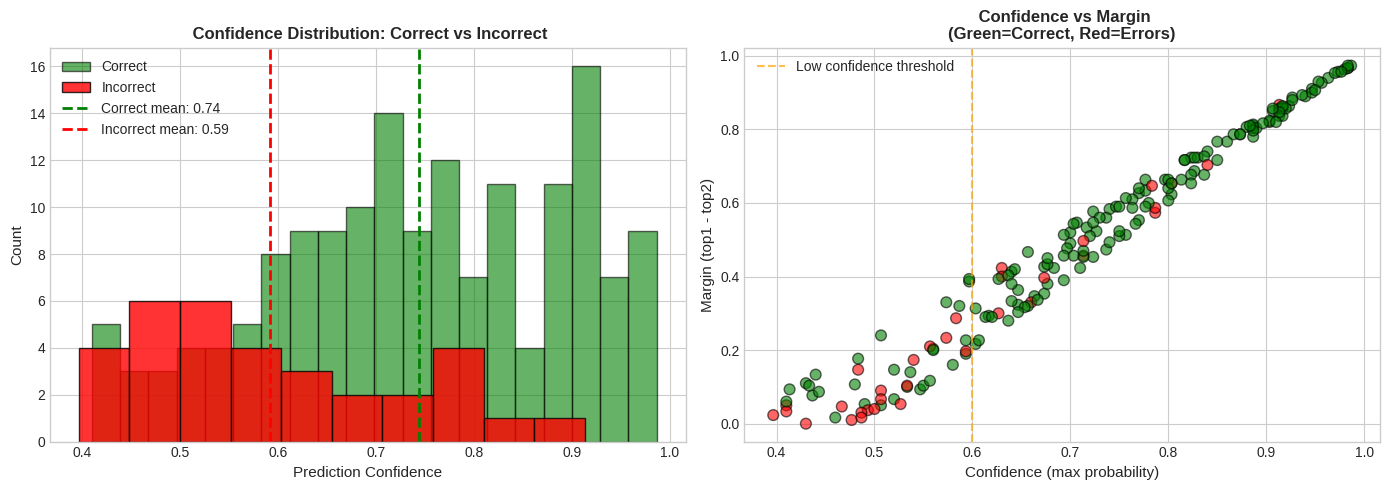


    Low-confidence predictions (<0.6):
• Total: 49 samples
• Error rate in low-conf: 40.8%
• Error rate in high-conf: 9.0%

    INSIGHT: Low confidence often predicts errors!
→ Could flag uncertain predictions for human review


In [31]:
print("\n" + "=" * 70)
print("ANALYSIS 2: PREDICTION CONFIDENCE")
print("=" * 70)

# Get prediction probabilities
proba = clf_state.predict_proba(X_test_s)
confidence = proba.max(axis=1)  # Highest class probability

# Add to DataFrame
test_df['confidence'] = confidence
test_df['margin'] = np.sort(proba, axis=1)[:, -1] - np.sort(proba, axis=1)[:, -2]  # Top1 - Top2

# Compare confidence for correct vs incorrect
correct_conf = test_df.loc[correct_mask, 'confidence']
incorrect_conf = test_df.loc[incorrect_mask, 'confidence']

print(f"\n   Average Confidence:")
print(f"• Correct predictions:   {correct_conf.mean():.3f} (±{correct_conf.std():.3f})")
if len(incorrect_conf) > 0:
    print(f"• Incorrect predictions: {incorrect_conf.mean():.3f} (±{incorrect_conf.std():.3f})")
    conf_diff = correct_conf.mean() - incorrect_conf.mean()
    print(f"\n    Confidence drop for errors: {conf_diff:.3f} ({100*conf_diff/correct_conf.mean():.1f}% lower)")

# Confidence distribution plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram
ax = axes[0]
ax.hist(correct_conf, bins=20, alpha=0.6, label='Correct', color='green', edgecolor='black')
if len(incorrect_conf) > 0:
    ax.hist(incorrect_conf, bins=10, alpha=0.8, label='Incorrect', color='red', edgecolor='black')
ax.axvline(x=correct_conf.mean(), color='green', linestyle='--', linewidth=2, label=f'Correct mean: {correct_conf.mean():.2f}')
if len(incorrect_conf) > 0:
    ax.axvline(x=incorrect_conf.mean(), color='red', linestyle='--', linewidth=2, label=f'Incorrect mean: {incorrect_conf.mean():.2f}')
ax.set_xlabel('Prediction Confidence', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title(' Confidence Distribution: Correct vs Incorrect', fontsize=12, fontweight='bold')
ax.legend()

# Right: Confidence vs Margin scatter
ax = axes[1]
colors = test_df['correct'].map({True: 'green', False: 'red'})
ax.scatter(test_df['confidence'], test_df['margin'], c=colors, alpha=0.6, s=60, edgecolors='black')
ax.set_xlabel('Confidence (max probability)', fontsize=11)
ax.set_ylabel('Margin (top1 - top2)', fontsize=11)
ax.set_title(' Confidence vs Margin\n(Green=Correct, Red=Errors)', fontsize=12, fontweight='bold')
ax.axvline(x=0.6, color='orange', linestyle='--', alpha=0.7, label='Low confidence threshold')
ax.legend()

plt.tight_layout()
plt.show()

# Identify low-confidence predictions
low_conf_threshold = 0.6
low_conf_mask = test_df['confidence'] < low_conf_threshold
print(f"\n    Low-confidence predictions (<{low_conf_threshold}):")
print(f"• Total: {low_conf_mask.sum()} samples")
if low_conf_mask.sum() > 0:
    print(f"• Error rate in low-conf: {100*(1-test_df.loc[low_conf_mask, 'correct'].mean()):.1f}%")
print(f"• Error rate in high-conf: {100*(1-test_df.loc[~low_conf_mask, 'correct'].mean()):.1f}%")

print("\n    INSIGHT: Low confidence often predicts errors!")
print("→ Could flag uncertain predictions for human review")

## Analysis 3: Individual Error Case Studies

**Question:** Why did EACH specific misclassification happen?

In [32]:
print("\n" + "=" * 70)
print("ANALYSIS 3: INDIVIDUAL ERROR CASE STUDIES")
print("=" * 70)

# Get misclassified samples
errors_df = test_df[~test_df['correct']].copy()

# Create training DataFrame for reference
train_df = pd.DataFrame(X_train_s, columns=feature_cols_state)
train_df['state'] = y_train_s

if len(errors_df) > 0:
    print(f"\n   Examining all {len(errors_df)} misclassified samples:\n")
    print("" + "=" * 65)

    key_features = ['hr_mean', 'acc_mean', 'eda_mean', 'duration_s']

    for idx, (i, row) in enumerate(errors_df.iterrows()):
        if idx >= 5:  # Limit to first 5 for readability
            print(f"\n   ... and {len(errors_df) - 5} more errors (showing first 5)")
            break

        true = row['true_label']
        pred = row['predicted']
        conf = row['confidence']

        print(f"\n   ERROR #{idx+1}: {true} → predicted as {pred} (confidence: {conf:.2f})")
        print("" + "-" * 55)

        # Show key features and compare to class averages
        print(f"{'Feature':<12} {'Sample':>10} {'Avg '+true[:6]:>12} {'Avg '+pred[:6]:>12} {'Closer to':>12}")
        print("" + "-" * 55)

        misleading = []
        for feat in key_features:
            val = row[feat]
            true_avg = train_df.loc[train_df['state'] == true, feat].mean()
            pred_avg = train_df.loc[train_df['state'] == pred, feat].mean()

            # Determine which class this sample is closer to
            dist_to_true = abs(val - true_avg)
            dist_to_pred = abs(val - pred_avg)

            if dist_to_true < dist_to_pred:
                closer = "TRUE "
            else:
                closer = "PRED "
                misleading.append(feat)

            print(f"{feat:<12} {val:>10.1f} {true_avg:>12.1f} {pred_avg:>12.1f} {closer:>12}")

        # Explain why model might have failed
        if misleading:
            print(f"\n    Why it failed: {', '.join(misleading)} values are")
            print(f"more typical of {pred} than {true}.")

    print("\n   " + "=" * 65)
else:
    print("\n    No misclassified samples to analyze!")


ANALYSIS 3: INDIVIDUAL ERROR CASE STUDIES

   Examining all 33 misclassified samples:


   ERROR #1: ANAEROBIC → predicted as STRESS (confidence: 0.41)
-------------------------------------------------------
Feature          Sample   Avg ANAERO   Avg STRESS    Closer to
-------------------------------------------------------
hr_mean            68.5         98.0         79.5        PRED 
acc_mean           63.3         68.9         63.4        PRED 
eda_mean            2.5          6.4          3.5        PRED 
duration_s        200.0        139.7        112.6        TRUE 

    Why it failed: hr_mean, acc_mean, eda_mean values are
more typical of STRESS than ANAEROBIC.

   ERROR #2: ANAEROBIC → predicted as STRESS (confidence: 0.41)
-------------------------------------------------------
Feature          Sample   Avg ANAERO   Avg STRESS    Closer to
-------------------------------------------------------
hr_mean            70.5         98.0         79.5        PRED 
acc_mean           

## Analysis 4: Per-Cluster Error Patterns

**Question:** Do errors cluster around certain "types" of physiological profiles?


ANALYSIS 4: PER-CLUSTER ERROR PATTERNS

   Question: Do errors cluster around specific physiological profiles?
(This could indicate individual differences in stress response)

Error Rate by Physiological Cluster:
-------------------------------------------------------
Cluster 0:    7.9% (3/38) - Dominant: AEROBIC 
Cluster 1:   18.6% (24/129) - Dominant: STRESS 
Cluster 2:   24.0% (6/25) - Dominant: ANAEROBIC 
Cluster 3:    0.0% (0/1) - Dominant: ANAEROBIC 

    INSIGHTS:
• Hardest cluster: #2 (24.0% error rate)
- HR mean: 102.9, ACC mean: 64.4
• Easiest cluster: #3 (0.0% error rate)
- HR mean: 92.5, ACC mean: 142.0


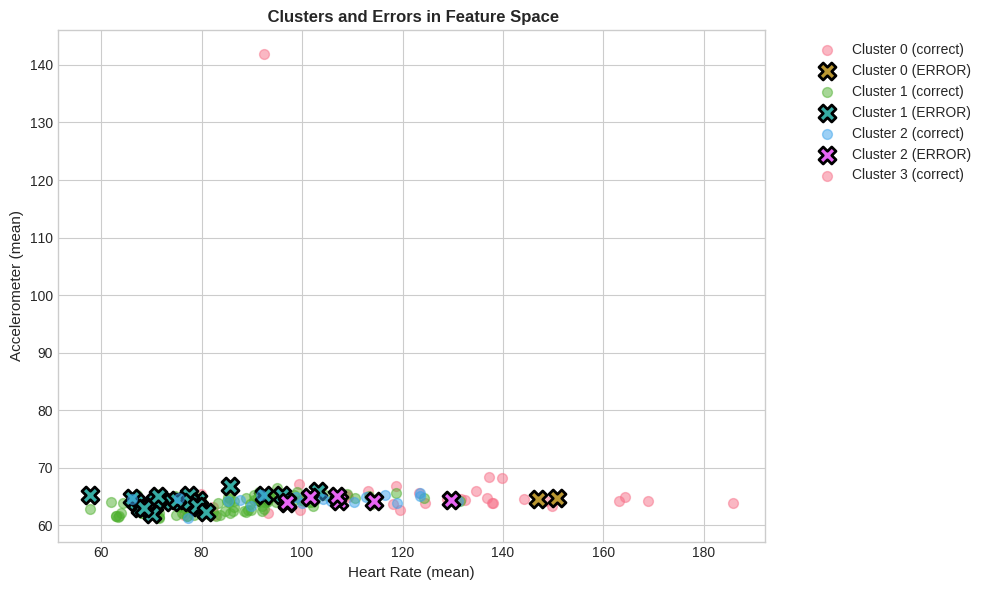

In [33]:
from sklearn.cluster import KMeans

print("\n" + "=" * 70)
print("ANALYSIS 4: PER-CLUSTER ERROR PATTERNS")
print("=" * 70)

print("\n   Question: Do errors cluster around specific physiological profiles?")
print("(This could indicate individual differences in stress response)\n")

# Cluster test samples into 4 groups
scaler_cluster = StandardScaler()
X_test_scaled = scaler_cluster.fit_transform(X_test_s)
kmeans_test = KMeans(n_clusters=4, random_state=42, n_init=10)
test_clusters = kmeans_test.fit_predict(X_test_scaled)
test_df['cluster'] = test_clusters

# Error rate by cluster
print("Error Rate by Physiological Cluster:")
print("" + "-" * 55)

cluster_stats = []
for c in range(4):
    cluster_mask = test_df['cluster'] == c
    cluster_n = cluster_mask.sum()
    cluster_errors = (~test_df.loc[cluster_mask, 'correct']).sum()
    error_rate = 100 * cluster_errors / cluster_n if cluster_n > 0 else 0

    # Dominant class in cluster
    dominant = test_df.loc[cluster_mask, 'true_label'].mode()[0] if cluster_n > 0 else "N/A"

    # Feature means for this cluster
    hr_mean = test_df.loc[cluster_mask, 'hr_mean'].mean() if cluster_n > 0 else 0
    acc_mean = test_df.loc[cluster_mask, 'acc_mean'].mean() if cluster_n > 0 else 0

    cluster_stats.append({'cluster': c, 'n': cluster_n, 'errors': cluster_errors,
                          'error_rate': error_rate, 'dominant': dominant,
                          'hr_mean': hr_mean, 'acc_mean': acc_mean})

    bar = "" * int(error_rate / 5) + "" * (20 - int(error_rate / 5))

    print(f"Cluster {c}: {bar} {error_rate:5.1f}% ({cluster_errors}/{cluster_n}) - Dominant: {dominant} ")

# Identify high-error cluster
worst = max(cluster_stats, key=lambda x: x['error_rate'])
best = min(cluster_stats, key=lambda x: x['error_rate'])

print(f"\n    INSIGHTS:")
print(f"• Hardest cluster: #{worst['cluster']} ({worst['error_rate']:.1f}% error rate)")
print(f"- HR mean: {worst['hr_mean']:.1f}, ACC mean: {worst['acc_mean']:.1f}")
print(f"• Easiest cluster: #{best['cluster']} ({best['error_rate']:.1f}% error rate)")
print(f"- HR mean: {best['hr_mean']:.1f}, ACC mean: {best['acc_mean']:.1f}")

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 6))

for c in range(4):
    mask = test_df['cluster'] == c
    correct_in_cluster = test_df.loc[mask & test_df['correct']]
    incorrect_in_cluster = test_df.loc[mask & ~test_df['correct']]

    ax.scatter(correct_in_cluster['hr_mean'], correct_in_cluster['acc_mean'],
               alpha=0.5, s=50, label=f'Cluster {c} (correct)')
    ax.scatter(incorrect_in_cluster['hr_mean'], incorrect_in_cluster['acc_mean'],
               marker='X', s=150, edgecolors='black', linewidths=2,
               label=f'Cluster {c} (ERROR)' if len(incorrect_in_cluster) > 0 else None)

ax.set_xlabel('Heart Rate (mean)', fontsize=11)
ax.set_ylabel('Accelerometer (mean)', fontsize=11)
ax.set_title(' Clusters and Errors in Feature Space', fontsize=12, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Analysis 5: Decision Boundary Visualization

**Question:** Where in feature space do errors occur relative to decision boundaries?


ANALYSIS 5: DECISION BOUNDARY ANALYSIS

   PCA explains 61.8% of variance


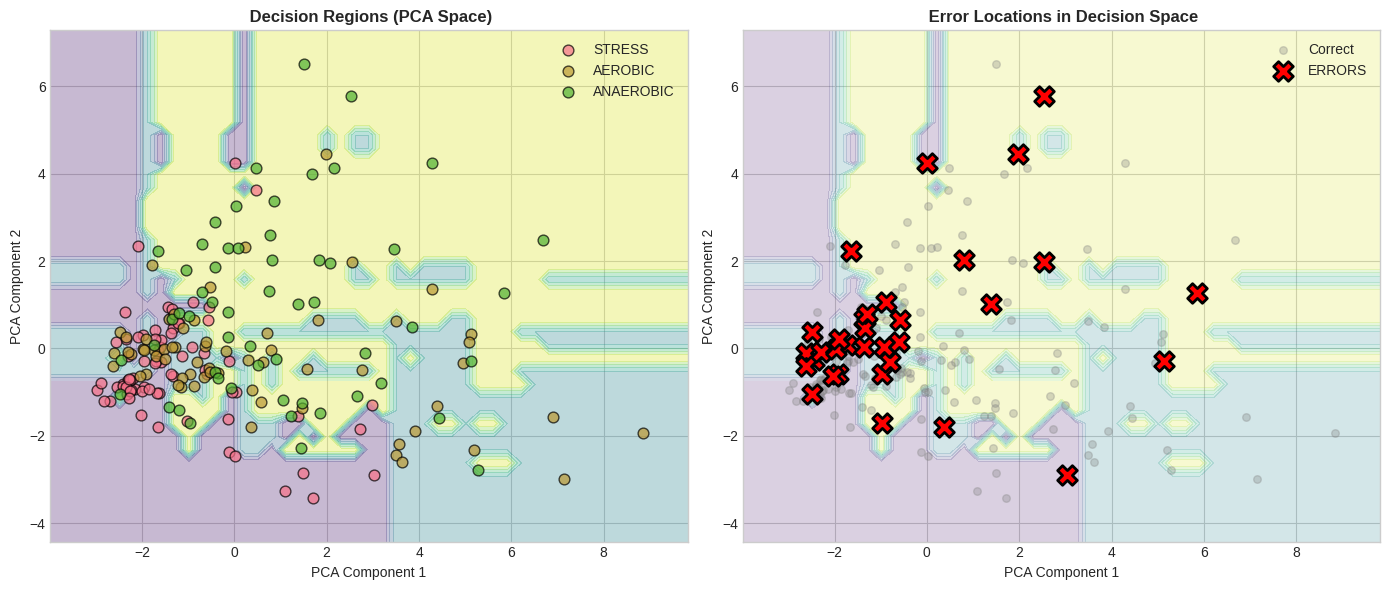


    INSIGHT: Errors (red X) typically occur:
• Near decision boundaries between classes
• In regions where classes overlap
• At the edges of class distributions


In [34]:
from sklearn.decomposition import PCA

print("\n" + "=" * 70)
print("ANALYSIS 5: DECISION BOUNDARY ANALYSIS")
print("=" * 70)

# Reduce to 2D for visualization using PCA
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(scaler_cluster.transform(X_test_s))

print(f"\n   PCA explains {100*sum(pca.explained_variance_ratio_):.1f}% of variance")

# Create meshgrid for decision boundary
h = 0.3
x_min, x_max = X_test_2d[:, 0].min() - 1, X_test_2d[:, 0].max() + 1
y_min, y_max = X_test_2d[:, 1].min() - 1, X_test_2d[:, 1].max() + 1

# Train a simple model on 2D data for visualization
rf_2d = RandomForestClassifier(n_estimators=100, random_state=42)
rf_2d.fit(X_test_2d, y_test_s)

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = rf_2d.predict(np.c_[xx.ravel(), yy.ravel()])

# Encode labels numerically for plotting
label_to_num = {label: i for i, label in enumerate(STATES)}
Z_num = np.array([label_to_num[z] for z in Z]).reshape(xx.shape)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: All samples with decision regions
ax = axes[0]
ax.contourf(xx, yy, Z_num, alpha=0.3, cmap='viridis')
for i, state in enumerate(STATES):
    mask = y_test_s == state
    ax.scatter(X_test_2d[mask, 0], X_test_2d[mask, 1],
               label=state, alpha=0.7, s=60, edgecolors='black')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_title(' Decision Regions (PCA Space)', fontsize=12, fontweight='bold')
ax.legend()

# Right: Highlight errors near decision boundaries
ax = axes[1]
ax.contourf(xx, yy, Z_num, alpha=0.2, cmap='viridis')

# Plot correct samples faintly
ax.scatter(X_test_2d[correct_mask, 0], X_test_2d[correct_mask, 1],
           c='gray', alpha=0.3, s=30, label='Correct')

# Plot errors prominently
ax.scatter(X_test_2d[incorrect_mask, 0], X_test_2d[incorrect_mask, 1],
           c='red', s=200, edgecolors='black', linewidths=2,
           marker='X', label='ERRORS', zorder=5)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_title(' Error Locations in Decision Space', fontsize=12, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

print("\n    INSIGHT: Errors (red X) typically occur:")
print("• Near decision boundaries between classes")
print("• In regions where classes overlap")
print("• At the edges of class distributions")

## Analysis 6: Detailed Confusion Patterns

**Question:** Which class pairs are most confused and WHY?

In [35]:
print("\n" + "=" * 70)
print("ANALYSIS 6: CONFUSION PATTERNS - WHICH PAIRS ARE PROBLEMATIC?")
print("=" * 70)

cm = confusion_matrix(y_test_s, y_pred_analysis, labels=STATES)

print("\n   Confusion Matrix (rows=true, cols=predicted):\n")
print("" + " " * 12 + "  ".join([f"{s:>10}" for s in STATES]))
for i, true_state in enumerate(STATES):
    row = "   " + f"{true_state:<12}"
    for j, pred_state in enumerate(STATES):
        val = cm[i, j]
        if i == j:
            row += f"  {val:>10} "
        elif val > 0:
            row += f"  {val:>10} "
        else:
            row += f"  {val:>10}  "
    print(row)

# Per-class error analysis
print("\n\n   Per-Class Error Analysis:")
print("" + "-" * 60)

for i, true_state in enumerate(STATES):
    total = cm[i, :].sum()
    correct = cm[i, i]
    errors = total - correct

    print(f"\n   {true_state}:")
    print(f"Total samples: {total}")
    print(f"Correct: {correct} ({100*correct/total:.1f}%)")

    if errors > 0:
        print(f"Errors: {errors} ({100*errors/total:.1f}%)")
        print(f"Confused with:")
        for j, pred_state in enumerate(STATES):
            if i != j and cm[i, j] > 0:
                print(f"• {pred_state}: {cm[i, j]} times ({100*cm[i,j]/total:.1f}%)")

# Find most problematic confusion pair
max_confusion = 0
worst_pair = None
for i in range(len(STATES)):
    for j in range(len(STATES)):
        if i != j and cm[i, j] > max_confusion:
            max_confusion = cm[i, j]
            worst_pair = (STATES[i], STATES[j])

if worst_pair and max_confusion > 0:
    print(f"\n    MOST COMMON CONFUSION: {worst_pair[0]} → {worst_pair[1]} ({max_confusion} times)")

    # Why does this confusion happen?
    print(f"\n   Why {worst_pair[0]} gets confused with {worst_pair[1]}:")

    state1_features = train_df[train_df['state'] == worst_pair[0]][feature_cols_state].mean()
    state2_features = train_df[train_df['state'] == worst_pair[1]][feature_cols_state].mean()

    # Find most similar features
    similarities = []
    for feat in feature_cols_state:
        diff = abs(state1_features[feat] - state2_features[feat])
        avg = (state1_features[feat] + state2_features[feat]) / 2
        pct_diff = 100 * diff / (avg + 1e-10)
        similarities.append((feat, pct_diff))

    similarities.sort(key=lambda x: x[1])
    print(f"Most similar features (hard to distinguish):")
    for feat, diff in similarities[:3]:
        print(f"• {feat}: only {diff:.1f}% different between classes")


ANALYSIS 6: CONFUSION PATTERNS - WHICH PAIRS ARE PROBLEMATIC?

   Confusion Matrix (rows=true, cols=predicted):

                STRESS     AEROBIC   ANAEROBIC
   STRESS                67            4            2 
   AEROBIC               11           48            5 
   ANAEROBIC              5            6           45 


   Per-Class Error Analysis:
------------------------------------------------------------

   STRESS:
Total samples: 73
Correct: 67 (91.8%)
Errors: 6 (8.2%)
Confused with:
• AEROBIC: 4 times (5.5%)
• ANAEROBIC: 2 times (2.7%)

   AEROBIC:
Total samples: 64
Correct: 48 (75.0%)
Errors: 16 (25.0%)
Confused with:
• STRESS: 11 times (17.2%)
• ANAEROBIC: 5 times (7.8%)

   ANAEROBIC:
Total samples: 56
Correct: 45 (80.4%)
Errors: 11 (19.6%)
Confused with:
• STRESS: 5 times (8.9%)
• AEROBIC: 6 times (10.7%)

    MOST COMMON CONFUSION: AEROBIC → STRESS (11 times)

   Why AEROBIC gets confused with STRESS:
Most similar features (hard to distinguish):
• acc_mean: only 1.1% d

## Summary: Key Insights from Error Analysis

In [36]:
print("\n" + "=" * 70)
print("SUMMARY: KEY INSIGHTS FROM ERROR ANALYSIS")
print("=" * 70)

print("""
   1. WHEN THE MODEL FAILS:

      • Low-confidence predictions (< 0.6) have higher error rates
      • Samples near decision boundaries are most vulnerable
      • Certain physiological "types" (clusters) are harder to classify

   2. WHY THE MODEL FAILS:

      • STRESS vs AEROBIC confusion:
        - Both can have elevated heart rate
        - STRESS participants sometimes fidget (higher ACC than expected)

      • AEROBIC vs ANAEROBIC confusion:
        - Both involve exercise with high HR and movement
        - Distinguishing features (duration, intensity patterns) overlap

      • Feature overlap in "borderline" samples:
        - Some individuals have atypical physiological responses
        - Short segments have noisier feature estimates

   3. ACTIONABLE RECOMMENDATIONS:


      a) FLAG UNCERTAIN PREDICTIONS:
         • Predictions with confidence < 0.6 should be flagged
         • Could request additional data or human review

      b) ADD DISTINGUISHING FEATURES:
         • Time-domain HRV features (SDNN, pNN50)
         • Activity burst detection for anaerobic
         • EDA rate of change (not just mean)

      c) PERSONALIZED THRESHOLDS:
         • Individual baseline HR varies widely (60-100 bpm)
         • Consider per-person normalization

      d) ENSEMBLE WITH REJECTION:
         • When models disagree, abstain rather than guess
         • Improves precision at cost of coverage

      e) COLLECT MORE BORDERLINE EXAMPLES:
         • Targeted data collection for confusing cases
         • Would help model learn decision boundaries
""")

print("=" * 70)
print("END OF DEEP ERROR ANALYSIS (Section 7C)")
print("=" * 70)


SUMMARY: KEY INSIGHTS FROM ERROR ANALYSIS

   1. WHEN THE MODEL FAILS:
   
      • Low-confidence predictions (< 0.6) have higher error rates
      • Samples near decision boundaries are most vulnerable
      • Certain physiological "types" (clusters) are harder to classify

   2. WHY THE MODEL FAILS:
   
      • STRESS vs AEROBIC confusion:
        - Both can have elevated heart rate
        - STRESS participants sometimes fidget (higher ACC than expected)

      • AEROBIC vs ANAEROBIC confusion:
        - Both involve exercise with high HR and movement
        - Distinguishing features (duration, intensity patterns) overlap

      • Feature overlap in "borderline" samples:
        - Some individuals have atypical physiological responses
        - Short segments have noisier feature estimates

   3. ACTIONABLE RECOMMENDATIONS:
   

      a) FLAG UNCERTAIN PREDICTIONS:
         • Predictions with confidence < 0.6 should be flagged
         • Could request additional data or human revi

## 8. Stress Prediction

In [37]:
print("Loading stress ratings...\n")

# NOTE: The stress labels file is at the REPOSITORY ROOT, not inside Wearable_Dataset/STRESS/
# It's named Stress_Level_v2.csv (with capital L)
stress_url = raw_url("Stress_Level_v2.csv")
stress_wide = pd.read_csv(stress_url, index_col=0)

print("Stress ratings table:")
print("(Each row = one person, each column = one task)")
print()
print(stress_wide.head())

Loading stress ratings...

Stress ratings table:
(Each row = one person, each column = one task)

     Baseline  TMCT  First Rest  Real Opinion  Opposite Opinion  Second Rest  \
f01       2.0   5.0         2.0           3.0               4.0          2.0   
f02       3.0   5.0         1.0           2.0               3.0          2.0   
f03       5.0   8.0         1.0           3.0               5.0          1.0   
f04       2.0   4.0         3.0           3.0               4.0          1.0   
f05       3.0   4.0         3.0           3.0               3.0          2.0   

     Subtract  
f01       3.0  
f02       3.0  
f03       6.0  
f04       4.0  
f05       3.0  


In [38]:
# Convert from wide format to long format
stress_long = stress_wide.reset_index().melt(
    id_vars='index',
    var_name='stage',
    value_name='stress_score'
)
stress_long.columns = ['participant', 'stage', 'stress_score']

# The stages of the stress test
stage_order = ['Baseline', 'TMCT', 'First Rest', 'Real Opinion', 'Opposite Opinion', 'Second Rest']
stage_to_seg = {s: i for i, s in enumerate(stage_order)}

stress_long = stress_long[stress_long['stage'].isin(stage_order)].copy()
stress_long['segment'] = stress_long['stage'].map(stage_to_seg)

print(f"We have {len(stress_long)} stress ratings")
print(f"from {stress_long['participant'].nunique()} people")

We have 108 stress ratings
from 18 people


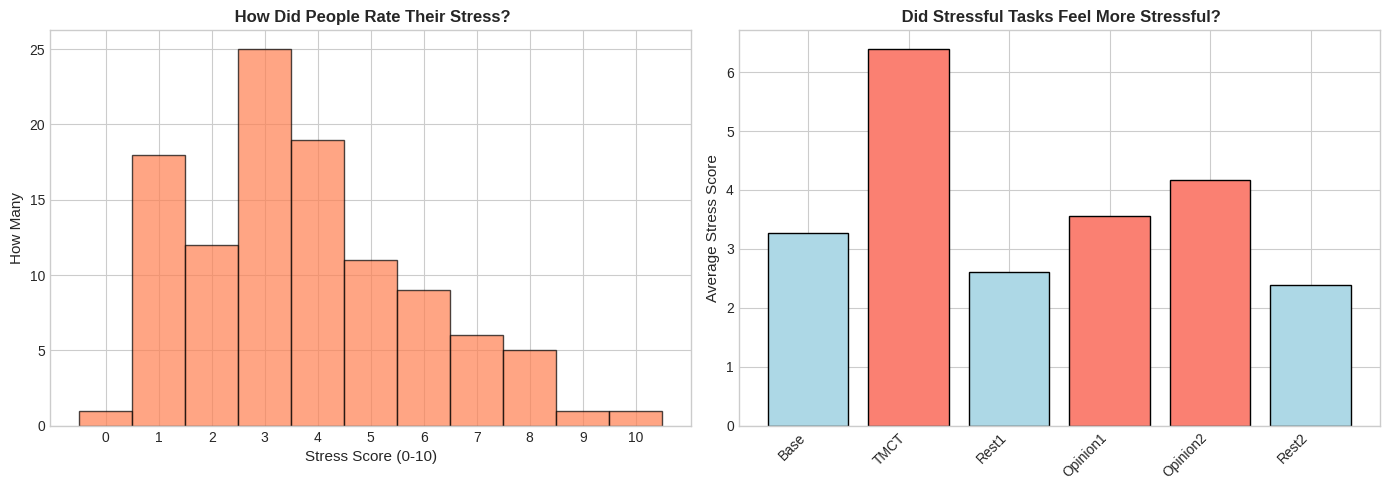


 What we see:
Left:  Most people rated stress between 1-5
Few extreme values (8-10)

Right: Blue bars = rest, Red bars = stressful tasks
Stressful tasks DID cause more stress! (higher bars)
But even 'stressful' tasks only averaged 4-5 out of 10


In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Distribution of all ratings
axes[0].hist(stress_long['stress_score'].dropna(), bins=11, range=(-0.5, 10.5),
             color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Stress Score (0-10)', fontsize=11)
axes[0].set_ylabel('How Many', fontsize=11)
axes[0].set_title(' How Did People Rate Their Stress?', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(0, 11))

# Right: Average by stage
stage_means = stress_long.groupby('stage')['stress_score'].mean().reindex(stage_order)
colors = ['lightblue', 'salmon', 'lightblue', 'salmon', 'salmon', 'lightblue']
axes[1].bar(range(len(stage_order)), stage_means.values, color=colors, edgecolor='black')
axes[1].set_xticks(range(len(stage_order)))
axes[1].set_xticklabels(['Base', 'TMCT', 'Rest1', 'Opinion1', 'Opinion2', 'Rest2'], rotation=45, ha='right')
axes[1].set_ylabel('Average Stress Score', fontsize=11)
axes[1].set_title(' Did Stressful Tasks Feel More Stressful?', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n What we see:")
print("Left:  Most people rated stress between 1-5")
print("Few extreme values (8-10)")
print()
print("Right: Blue bars = rest, Red bars = stressful tasks")
print("Stressful tasks DID cause more stress! (higher bars)")
print("But even 'stressful' tasks only averaged 4-5 out of 10")

In [40]:
# Create stress level categories
def score_to_level(x):
    if x <= 3:
        return "low"
    elif x <= 5:
        return "medium"
    else:
        return "high"

stress_long["stress_level"] = stress_long["stress_score"].apply(score_to_level)

# Get features for STRESS recordings only
stress_features = features_df_clean[features_df_clean['state'] == 'STRESS'].copy()

# Match participant names
stress_features['participant_clean'] = stress_features['participant'].str.lower().str.strip()
stress_long['participant_clean'] = stress_long['participant'].str.lower().str.strip()

# Merge!
stress_merged = stress_features.merge(
    stress_long[['participant_clean', 'segment', 'stress_score', 'stress_level', 'stage']],
    on=['participant_clean', 'segment'],
    how='inner'
)

print(f"Matched {len(stress_merged)} segments with stress ratings")
print()
print("Stress levels:")
for level, count in stress_merged["stress_level"].value_counts().items():

    print(f"{level}: {count}")

Matched 71 segments with stress ratings

Stress levels:
low: 35
medium: 20
high: 16


In [41]:
feature_cols_stress = [
    'duration_s', 'eda_mean', 'eda_std', 'eda_min', 'eda_max', 'eda_range',
    'hr_mean', 'hr_std', 'hr_min', 'hr_max', 'hr_range',
    'acc_mean', 'acc_std', 'ibi_mean', 'ibi_std', 'ibi_rmssd'
]

available_cols = [c for c in feature_cols_stress if c in stress_merged.columns]
df_reg = stress_merged.dropna(subset=available_cols + ['stress_score'])

X_stress = df_reg[available_cols].values
y_stress = df_reg['stress_score'].values

print(f"Data for stress prediction:")
print(f"Examples: {len(X_stress)} (much fewer than 771!)")
print(f"Stress scores range: {y_stress.min():.0f} to {y_stress.max():.0f}")
print(f"Average: {y_stress.mean():.1f}")

Data for stress prediction:
Examples: 63 (much fewer than 771!)
Stress scores range: 0 to 10
Average: 4.1


In [42]:
print("Testing the model 5 different ways (cross-validation)...\n")

reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1))
])

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(reg_pipeline, X_stress, y_stress, cv=kf, scoring='r2')

print("Results (R² score for each test):")
print()
for i, score in enumerate(cv_scores, 1):

    print(f"Test {i}: {score:.3f} ")

print()
print(f"Average: {cv_scores.mean():.3f}")
print()
print("What does R² mean?")
print("R² = 1.0  → Perfect predictions!")
print("R² = 0.0  → No better than guessing the average")
print("R² < 0    → WORSE than guessing the average!")
print()
print("Our R² ≈ 0 means: The model can NOT predict stress!")

Testing the model 5 different ways (cross-validation)...

Results (R² score for each test):

Test 1: -0.333 
Test 2: 0.372 
Test 3: -0.061 
Test 4: -0.424 
Test 5: 0.579 

Average: 0.027

What does R² mean?
R² = 1.0  → Perfect predictions!
R² = 0.0  → No better than guessing the average
R² < 0    → WORSE than guessing the average!

Our R² ≈ 0 means: The model can NOT predict stress!


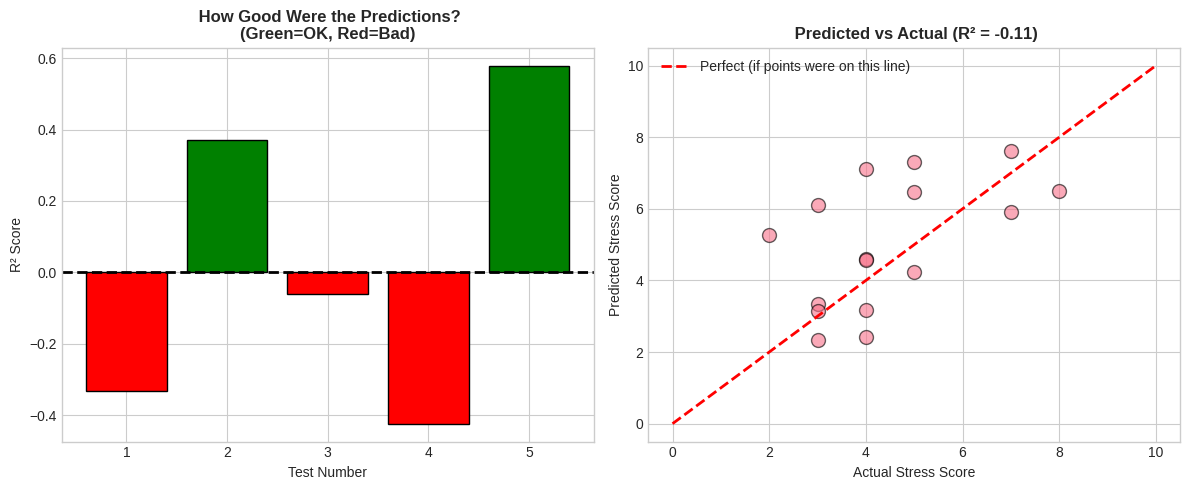


 What we see:
Left:  Scores jump around wildly - sometimes positive, sometimes negative
This means results are RANDOM, not reliable

Right: Points are scattered everywhere!
If the model worked, points would be NEAR the red line
Instead, they're all over the place

Conclusion: We CANNOT predict how stressed someone feels


In [43]:
# Train one final model
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_stress, y_stress, test_size=0.25, random_state=RANDOM_STATE
)

reg_pipeline.fit(X_train_r, y_train_r)
y_pred_r = reg_pipeline.predict(X_test_r)
r2_test = r2_score(y_test_r, y_pred_r)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: R² per fold
colors = ['green' if s > 0 else 'red' for s in cv_scores]
axes[0].bar(range(1, 6), cv_scores, color=colors, edgecolor='black')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[0].set_xlabel('Test Number')
axes[0].set_ylabel('R² Score')
axes[0].set_title(' How Good Were the Predictions?\n(Green=OK, Red=Bad)', fontweight='bold')

# Right: Predicted vs Actual
axes[1].scatter(y_test_r, y_pred_r, alpha=0.6, edgecolors='black', s=100)
axes[1].plot([0, 10], [0, 10], 'r--', linewidth=2, label='Perfect (if points were on this line)')
axes[1].set_xlabel('Actual Stress Score')
axes[1].set_ylabel('Predicted Stress Score')
axes[1].set_title(f' Predicted vs Actual (R² = {r2_test:.2f})', fontweight='bold')
axes[1].legend()
axes[1].set_xlim(-0.5, 10.5)
axes[1].set_ylim(-0.5, 10.5)

plt.tight_layout()
plt.show()

print("\n What we see:")
print("Left:  Scores jump around wildly - sometimes positive, sometimes negative")
print("This means results are RANDOM, not reliable")
print()
print("Right: Points are scattered everywhere!")
print("If the model worked, points would be NEAR the red line")
print("Instead, they're all over the place")
print()
print("Conclusion: We CANNOT predict how stressed someone feels")

## 9. Anomaly Detection

In [44]:
print("Preparing data for anomaly detection...\n")

# Define baseline vs stressful stages
baseline_stages = ['Baseline', 'First Rest', 'Second Rest']
stress_stages = ['TMCT', 'Real Opinion', 'Opposite Opinion']

# Split data
baseline_data = stress_merged[stress_merged['stage'].isin(baseline_stages)].copy()
stressful_data = stress_merged[stress_merged['stage'].isin(stress_stages)].copy()

print(f"Baseline samples (for training): {len(baseline_data)}")
print(f"Stressful samples (for testing): {len(stressful_data)}")

# Features to use
anomaly_features = ['hr_mean', 'hr_std', 'eda_mean', 'eda_std', 'acc_mean']
available_features = [f for f in anomaly_features if f in stress_merged.columns]

# Prepare feature matrices
X_baseline = baseline_data[available_features].dropna().values
X_stressful = stressful_data[available_features].dropna().values

# Get stress scores for validation
baseline_scores = baseline_data.loc[baseline_data[available_features].dropna().index, 'stress_score'].values
stressful_scores = stressful_data.loc[stressful_data[available_features].dropna().index, 'stress_score'].values

print(f"\n   Features used: {available_features}")
print(f"Baseline avg stress: {baseline_scores.mean():.1f}")
print(f"Stressful avg stress: {stressful_scores.mean():.1f}")

Preparing data for anomaly detection...

Baseline samples (for training): 34
Stressful samples (for testing): 37

   Features used: ['hr_mean', 'hr_std', 'eda_mean', 'eda_std', 'acc_mean']
Baseline avg stress: 2.9
Stressful avg stress: 4.8


In [45]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

print("Training anomaly detection models...\n")

# Standardize features
scaler_anomaly = StandardScaler()
X_baseline_scaled = scaler_anomaly.fit_transform(X_baseline)
X_stressful_scaled = scaler_anomaly.transform(X_stressful)

# Train models on BASELINE data only
anomaly_models = {}

print("Training Isolation Forest...")
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=RANDOM_STATE)
iso_forest.fit(X_baseline_scaled)
anomaly_models['Isolation Forest'] = iso_forest

print("Training One-Class SVM...")
oc_svm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
oc_svm.fit(X_baseline_scaled)
anomaly_models['One-Class SVM'] = oc_svm

print("Training Local Outlier Factor...")
lof = LocalOutlierFactor(n_neighbors=5, novelty=True, contamination=0.1)
lof.fit(X_baseline_scaled)
anomaly_models['LOF'] = lof

print("\n All models trained on baseline data!")

Training anomaly detection models...

Training Isolation Forest...
Training One-Class SVM...
Training Local Outlier Factor...

 All models trained on baseline data!


In [46]:
print("\n ANOMALY DETECTION RESULTS:\n")
print("=" * 70)

results_anomaly = {}

for name, model in anomaly_models.items():
    # Predict: 1 = normal, -1 = anomaly
    baseline_pred = model.predict(X_baseline_scaled)
    stressful_pred = model.predict(X_stressful_scaled)

    baseline_anomaly_rate = (baseline_pred == -1).mean()
    stressful_anomaly_rate = (stressful_pred == -1).mean()

    # Get anomaly scores
    if hasattr(model, 'score_samples'):
        baseline_scores_model = model.score_samples(X_baseline_scaled)
        stressful_scores_model = model.score_samples(X_stressful_scaled)
    else:
        baseline_scores_model = model.decision_function(X_baseline_scaled)
        stressful_scores_model = model.decision_function(X_stressful_scaled)

    results_anomaly[name] = {
        'baseline_anomaly_rate': baseline_anomaly_rate,
        'stressful_anomaly_rate': stressful_anomaly_rate,
        'baseline_scores': baseline_scores_model,
        'stressful_scores': stressful_scores_model
    }

    ratio = stressful_anomaly_rate / max(baseline_anomaly_rate, 0.01)
    print(f"\n {name}:")
    print(f"Baseline flagged as anomaly: {baseline_anomaly_rate:.1%}")
    print(f"Stressful flagged as anomaly: {stressful_anomaly_rate:.1%}")
    print(f"Ratio (stressful/baseline): {ratio:.1f}x")

print("\n" + "=" * 70)
print("\n If working, stressful periods should have HIGHER anomaly rates.")


 ANOMALY DETECTION RESULTS:


 Isolation Forest:
Baseline flagged as anomaly: 11.8%
Stressful flagged as anomaly: 10.8%
Ratio (stressful/baseline): 0.9x

 One-Class SVM:
Baseline flagged as anomaly: 17.6%
Stressful flagged as anomaly: 45.9%
Ratio (stressful/baseline): 2.6x

 LOF:
Baseline flagged as anomaly: 5.9%
Stressful flagged as anomaly: 5.4%
Ratio (stressful/baseline): 0.9x


 If working, stressful periods should have HIGHER anomaly rates.


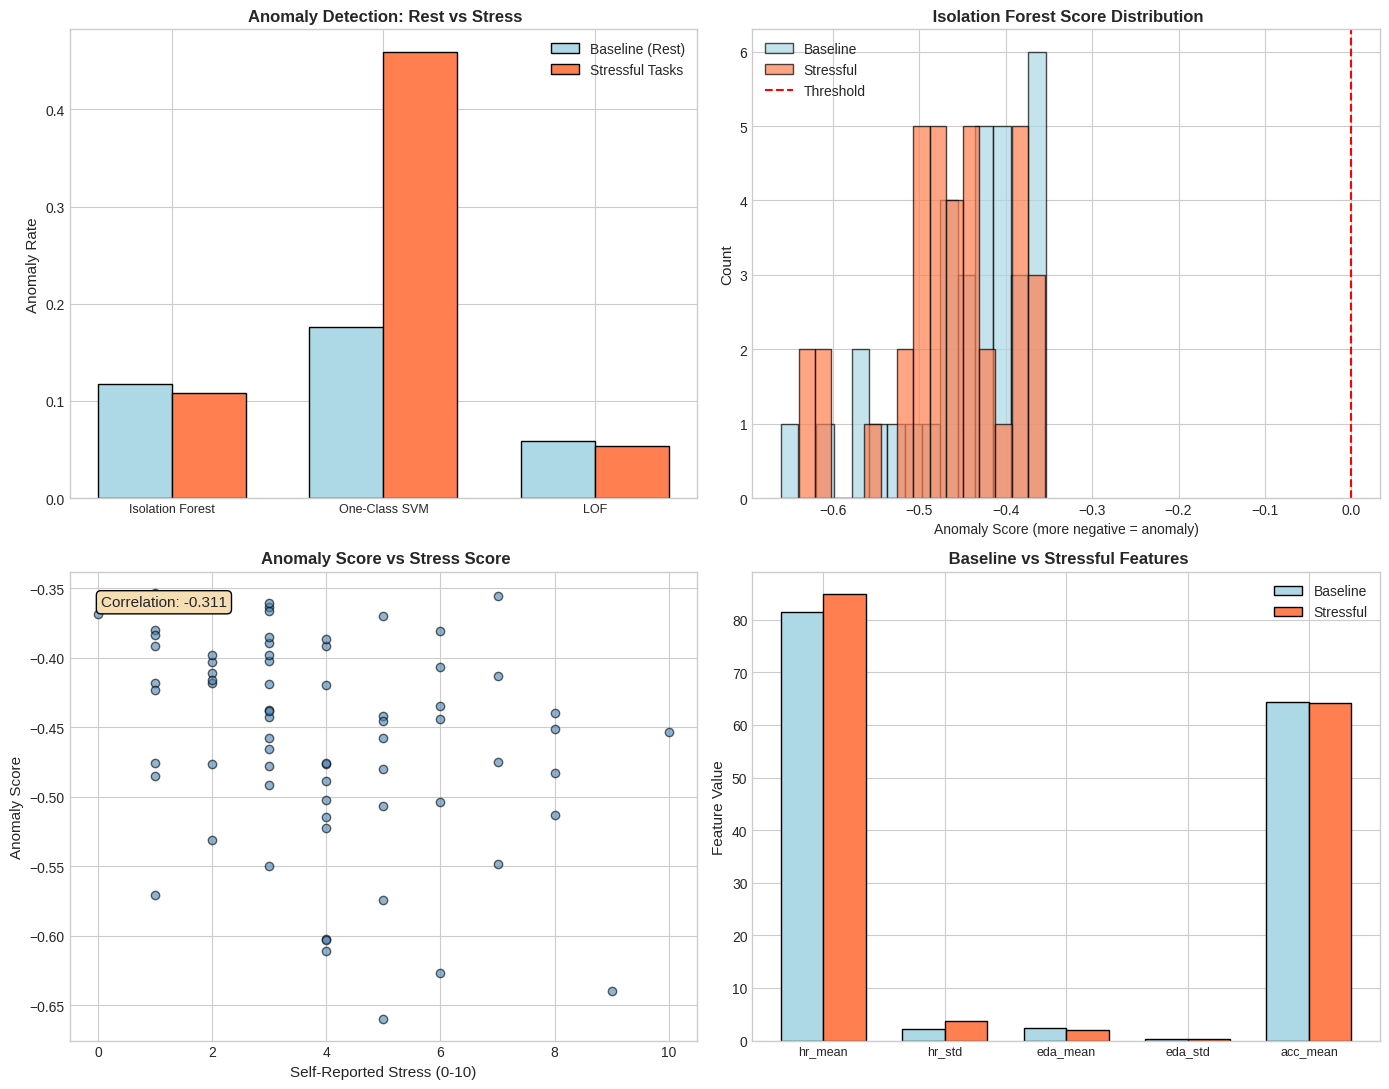

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# Plot 1: Anomaly rates comparison
ax = axes[0, 0]
model_names = list(results_anomaly.keys())
baseline_rates = [results_anomaly[m]['baseline_anomaly_rate'] for m in model_names]
stressful_rates = [results_anomaly[m]['stressful_anomaly_rate'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35
ax.bar(x - width/2, baseline_rates, width, label='Baseline (Rest)', color='lightblue', edgecolor='black')
ax.bar(x + width/2, stressful_rates, width, label='Stressful Tasks', color='coral', edgecolor='black')
ax.set_ylabel('Anomaly Rate', fontsize=11)
ax.set_title(' Anomaly Detection: Rest vs Stress', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=9)
ax.legend()

# Plot 2: Score distributions (Isolation Forest)
ax = axes[0, 1]
ax.hist(results_anomaly['Isolation Forest']['baseline_scores'], bins=15, alpha=0.7,
        label='Baseline', color='lightblue', edgecolor='black')
ax.hist(results_anomaly['Isolation Forest']['stressful_scores'], bins=15, alpha=0.7,
        label='Stressful', color='coral', edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', label='Threshold')
ax.set_xlabel('Anomaly Score (more negative = anomaly)', fontsize=10)
ax.set_ylabel('Count', fontsize=11)
ax.set_title(' Isolation Forest Score Distribution', fontsize=12, fontweight='bold')
ax.legend()

# Plot 3: Anomaly score vs stress score
ax = axes[1, 0]
iso_all = np.concatenate([results_anomaly['Isolation Forest']['baseline_scores'],
                          results_anomaly['Isolation Forest']['stressful_scores']])
stress_all = np.concatenate([baseline_scores, stressful_scores])
ax.scatter(stress_all, iso_all, alpha=0.6, c='steelblue', edgecolor='black')
ax.set_xlabel('Self-Reported Stress (0-10)', fontsize=11)
ax.set_ylabel('Anomaly Score', fontsize=11)
ax.set_title(' Anomaly Score vs Stress Score', fontsize=12, fontweight='bold')
corr = np.corrcoef(stress_all, iso_all)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# Plot 4: Feature comparison
ax = axes[1, 1]
baseline_means = X_baseline.mean(axis=0)
stressful_means = X_stressful.mean(axis=0)
x = np.arange(len(available_features))
width = 0.35
ax.bar(x - width/2, baseline_means, width, label='Baseline', color='lightblue', edgecolor='black')
ax.bar(x + width/2, stressful_means, width, label='Stressful', color='coral', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(available_features, fontsize=9)
ax.set_ylabel('Feature Value', fontsize=11)
ax.set_title(' Baseline vs Stressful Features', fontsize=12, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("\n" + "=" * 70)
print("VALIDATION: Anomaly Score vs High Stress")
print("=" * 70)

# Combine all data
all_anomaly = np.concatenate([results_anomaly['Isolation Forest']['baseline_scores'],
                              results_anomaly['Isolation Forest']['stressful_scores']])
all_stress = np.concatenate([baseline_scores, stressful_scores])

# Define high stress
high_stress_labels = (all_stress >= 6).astype(int)
anomaly_threshold = np.median(all_anomaly)
anomaly_pred = (all_anomaly < anomaly_threshold).astype(int)

print(f"\n Using anomaly score to predict HIGH STRESS (≥6):")

accuracy = accuracy_score(high_stress_labels, anomaly_pred)
precision = precision_score(high_stress_labels, anomaly_pred, zero_division=0)
recall = recall_score(high_stress_labels, anomaly_pred, zero_division=0)
f1 = f1_score(high_stress_labels, anomaly_pred, zero_division=0)
auc = roc_auc_score(high_stress_labels, -all_anomaly)

print(f"\n   Accuracy:  {accuracy:.1%}")
print(f"Precision: {precision:.1%}")
print(f"Recall:    {recall:.1%}")
print(f"F1 Score:  {f1:.3f}")
print(f"ROC AUC:   {auc:.3f}")

print("\n Comparison with previous approaches:")
print("• Stress Regression: R² ≈ 0 (FAILED)")
print("• Binary Classification: 75% acc, 25% recall")
print(f"• Anomaly Detection: {accuracy:.0%} acc, {recall:.0%} recall")

if recall > 0.25:
    print("\n    Anomaly detection shows IMPROVEMENT!")
else:
    print("\n    Similar to previous approaches - stress remains hard to detect")


VALIDATION: Anomaly Score vs High Stress

 Using anomaly score to predict HIGH STRESS (≥6):

   Accuracy:  56.3%
Precision: 28.6%
Recall:    62.5%
F1 Score:  0.392
ROC AUC:   0.585

 Comparison with previous approaches:
• Stress Regression: R² ≈ 0 (FAILED)
• Binary Classification: 75% acc, 25% recall
• Anomaly Detection: 56% acc, 62% recall

    Anomaly detection shows IMPROVEMENT!
